In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16, vgg19
from torchvision import transforms
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Image Transformation Network
This is based on Justin C. Johnson's paper, [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf).
Here, we are going to make the proposed network for generating the end image (as in the convolutional neural network the will learn weights in order to efficiently calculate how to create an image based on a style)

### Architecture
![Architecture](./images/transformation-network-table.PNG)

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # For the transformation network, the authors only used 3x3 convolutions
        self.conv = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 3)
        self.batch_norm = nn.InstanceNorm2d(self.out_channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolution
        orig_x = x.clone()
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        
        # Second convolution
        x = self.conv(x)
        x = self.batch_norm(x)
        
        # Now add the original to the new one (and use center cropping)
        # Calulate the different between the size of each feature (in terms 
        # of height/width) to get the center of the original feature
        height_diff = orig_x.size()[2] - x.size()[2]
        width_diff = orig_x.size()[3] - x.size()[3]
        
        # Add the original to the new (complete the residual block)
        x = x + orig_x[:, :,
                                 height_diff//2:(orig_x.size()[2] - height_diff//2), 
                                 width_diff//2:(orig_x.size()[3] - width_diff//2)]
        
        return x

In [3]:
class ImageTransformationNetwork(nn.Module):
    def __init__(self):
        super(ImageTransformationNetwork, self).__init__()
        # Use reflection padding to keep the end shape
        self.ref_pad = nn.ReflectionPad2d(40)
        
        # Initial convolutions
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 32,
                               kernel_size = 9,
                               padding = 6,
                               padding_mode = 'reflect')
        
        self.conv2 = nn.Conv2d(in_channels = 32,
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = 64,
                               out_channels = 128,
                               kernel_size = 3,
                               stride = 2)
        
        # Residual Blocks
        self.resblock1 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock2 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock3 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock4 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock5 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        # Transpose convoltutions
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=128,
                                             out_channels=64,
                                             kernel_size=2,
                                             stride=2)
        
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64,
                                              out_channels=32,
                                              kernel_size=2,
                                              stride=2)
        
        # End with one last convolution
        self.conv4 = nn.Conv2d(in_channels = 32,
                               out_channels = 3,
                               kernel_size = 9,
                               padding = 4,
                               padding_mode = 'reflect')
        
    def forward(self, x):
        # Apply reflection padding
        x = self.ref_pad(x)
        
        # Apply the initial convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Apply the residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)        
        
        #  Apply the transpose convolutions
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)
        
        # Apply the final convolution
        x = self.conv4(x)
        
        return x

In [4]:
# Test to confirm the residual network works
resblock = ResidualBlock(128, 128)
test = torch.randn(2, 128, 84, 84)
out = resblock(test)
print(out.size())

torch.Size([2, 128, 80, 80])


In [5]:
# Test to confirm the transormational network works
transformation_net = ImageTransformationNetwork()
test = torch.randn(2, 3, 256, 256)
out = transformation_net(test)
print(out.size())

torch.Size([2, 3, 256, 256])


### Cost Functions
Now we must implement the different cost functions

Style Relu Indices: 3, 8, 15, 22  
Content Relu Index: 15

In [6]:
class ForwardVGG19(torch.nn.Module):
    def __init__(self):
        super(ForwardVGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()
        
    def forward(self, x, style):
        results = []
        for i, model in enumerate(self.features):
            x = model(x)
            if style:
                if i in {3, 8, 15, 22}:
                    results.append(x)
            
            else:
                if i == 15:
                    results.append(x)
        
        return results

forward_vgg = ForwardVGG19()

In [7]:
def normalize_batch(batch):
    """
    Before we send an image into the VGG19, we have to normalize it
    """
    # Define the means and standard deviations
    vgg_means = [0.485, 0.456, 0.406]
    vgg_std = [0.229, 0.224, 0.225]
    
    # Clone the batch to make changes to it
    ret = batch.clone()
    
    # Normalize to between 0 and 255 (input image is 255-value images, not floats)
    ret = ret / 255.0
    
    # Subtract the means and divide by the standard deviations
    ret[:, 0, :, :] = (ret[:, 0, :, :] - vgg_means[0]) / vgg_std[0]
    ret[:, 1, :, :] = (ret[:, 1, :, :] - vgg_means[1]) / vgg_std[1]
    ret[:, 2, :, :] = (ret[:, 2, :, :] - vgg_means[2]) / vgg_std[2]
    return ret

In [8]:
def denormalize_batch(batch):
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] + vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] + vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] + vgg_means[2]
    return ret

In [9]:
def add_noise(batch):
    """
    For the input image, we have to add noise so that the loss between the content image and 
    input image is not 0
    """
    mean = 0.0
    std = 10.0
    ret = batch + np.random.normal(mean, std, batch.shape)
    ret = np.clip(batch, 0, 255)
    return ret

In [73]:
def compute_gram(matrix):
    """
    Computes the gram matrix
    """
    batches, channels, height, width = matrix.size()
    return (1/(channels * height * width)) * (torch.matmul(matrix.view(batches, channels, -1),
                                                torch.transpose(matrix.view(batches, channels, -1), 1, 2)))


In [99]:
def content_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, False)
    target_layers = forward_vgg(target_norm, False)

    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + torch.mean(torch.square(input_layers[layer] - target_layers[layer]))
    
    return accumulated_loss

In [100]:
def style_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, True)
    target_layers = forward_vgg(target_norm, True)
    
    # layer weights
    layer_weights = [0.3, 0.7, 0.7, 0.3]
    
    # The accumulated losses for the style
    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + layer_weights[layer] * \
                            torch.mean(torch.square(compute_gram(input_layers[layer]) -
                                                    compute_gram(target_layers[layer])))
    
    return accumulated_loss

In [35]:
def total_variation_cost(input):
    tvloss = (
        torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + 
        torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
    )
    return tvloss

In [14]:
content_losses = []
style_losses = []
tv_losses = []

In [106]:
def total_cost(input, targets):
    # Weights
    REG_TV = 1e-6
    REG_STYLE = 1e6
    REG_CONTENT = 1.0
    
    # Extract content and style images
    content, style = targets
    
    # Get the content, style and tv variation losses
    closs = content_cost(input, content) * REG_CONTENT
    sloss = style_cost(input, style) * REG_STYLE
    tvloss = total_variation_cost(input) * REG_TV
        
    # Add it to the running list of losses
    content_losses.append(closs)
    style_losses.append(sloss)
    tv_losses.append(tvloss)
    
    print('****************************')
    print('Content Loss: {}'.format(closs.item()))
    print('Style Loss: {}'.format(sloss.item()))
    print('Total Variation Loss: {}'.format(tvloss.item()))
        
    # Apply the weights and add
    return closs + sloss + tvloss
    

### Data Loading

In [16]:
# Constants
IMG_DIMENSIONS = (256, 256)
DATA = list(glob.iglob('data/content_images/*'))
STYLE_IMAGE = np.asarray(Image.open('data/starry_night.jpeg').resize(IMG_DIMENSIONS)).transpose(2, 0, 1)[0:3]

# Make the style image a batch and convert
STYLE_IMAGE = STYLE_IMAGE.reshape(1, 3, 256, 256)
MAX_TRAIN = 80000
MAX_VAL = 81000
TOTAL_DATA = len(DATA)

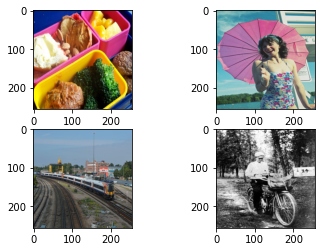

In [17]:
def show_sample_images():
    f, axarr = plt.subplots(2,2)
    
    # Show colored images
    axarr[0,0].imshow(np.asarray(Image.open(DATA[0]).resize(IMG_DIMENSIONS)))
    axarr[0,1].imshow(np.asarray(Image.open(DATA[4]).resize(IMG_DIMENSIONS)))
    axarr[1,0].imshow(np.asarray(Image.open(DATA[8]).resize(IMG_DIMENSIONS)))
    
    # Grayscale example
    grayscale = np.asarray(Image.open(DATA[13]).resize(IMG_DIMENSIONS))
    grayscale = np.stack((grayscale, grayscale, grayscale)).transpose(1, 2, 0)
    axarr[1,1].imshow(grayscale)
    
show_sample_images()

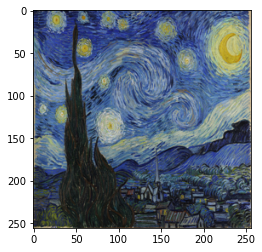

In [113]:
# Show the chosen style image
plt.imshow(STYLE_IMAGE[0].transpose(1, 2, 0))

In [19]:
def load_training_batch(current_batch, batch_size, set_type):
    """
    Load different batches of data (essentially a custom data loader for training, validation, and testing)
    """
    # The initial position is where we want to start getting the batch
    # So it is the starting index of the batch
    initial_pos = current_batch * batch_size
    
    # List to store the images
    images = []
    
    # Make sure the batch is within the [0, MAX_TRAIN]
    if set_type == 'train':
        if initial_pos + batch_size > MAX_TRAIN:
            batch_size = MAX_TRAIN - initial_pos
    
    # Make sure the batch is within the [MAX_TRAIN, MAX_VAL]
    elif set_type == 'val':
        initial_pos = MAX_TRAIN + initial_pos
        if initial_pos + batch_size > MAX_VAL:
            batch_size = MAX_VAL - initial_pos
    
    # Make sure the batch is within the [MAX_VAL, TOTAL_DATA]
    elif set_type == 'test':
        initial_pos = MAX_VAL + initial_pos
        if initial_pos + batch_size > TOTAL_DATA:
            batch_size = TOTAL_DATA - initial_pos

    for f in DATA[initial_pos:initial_pos + batch_size]:
        # Resize the image to 256 x 256
        image = np.asarray(Image.open(f).resize(IMG_DIMENSIONS))
        
        # If the image is grayscale, stack the image 3 times to get 3 channels
        if image.shape == IMG_DIMENSIONS:
            image = np.stack((image, image, image))
            images.append(image)
            continue
            
        # Transpose the image to have channels first
        image = image.transpose(2, 0, 1)
        images.append(image)
    
    return np.array(images)

In [20]:
def training_show_img():
    # Get an image from the validation set
    img = load_training_batch(0, 10, 'val')[4]
    
    # Convert to tensor
    train_img = torch.from_numpy(img.reshape(1, 3, 256, 256)).float()
    
    # Put through network
    gen_img = transformation_net(train_img)
    gen_img = gen_img.detach().numpy()
    
    # Clip the floats
    gen_img = np.clip(gen_img, 0, 255)
    
    # Convert to ints (for images)
    gen_img = gen_img.astype('uint8')
    gen_img = gen_img.reshape(3, 256, 256).transpose(1, 2, 0)
    
    # Show the image
    plt.imshow(gen_img)
    plt.show()

In [110]:
def show_img(img):
    # Convert to tensor
    img = torch.from_numpy(img.reshape(1, 3, 256, 256)).float()
    
    # Put through network
    gen_img = transformation_net(img)
    gen_img = gen_img.detach().numpy()
    
    # Clip the floats
    gen_img = np.clip(gen_img, 0, 255)
    
    # Convert to ints (for images)
    gen_img = gen_img.astype('uint8')
    gen_img = gen_img.reshape(3, 256, 256).transpose(1, 2, 0)
    
    # Show the image
    plt.imshow(gen_img)
    plt.show()

In [21]:
def plot_losses():
    # Print info about content losses
    plt.plot(content_losses[int(len(content_losses) * 0.0):])
    plt.show()
    print(content_losses[len(content_losses) - 1])

    # Print info about style losses
    plt.plot(style_losses[int(len(style_losses) * 0.0):])
    plt.show()
    print(style_losses[len(style_losses) - 1])

    # Print info about total variation losses
    plt.plot(tv_losses[int(len(tv_losses) * 0.0):])
    plt.show()
    print(tv_losses[len(tv_losses) - 1])

### Training

In [107]:
BATCH_SIZE = 4
STYLE_IMAGE_TENSOR = torch.from_numpy(np.copy(STYLE_IMAGE)).float()
transformation_net = ImageTransformationNetwork()
opt = optim.Adam(transformation_net.parameters(), lr=1e-3)

****************************
Content Loss: 20.71750831604004
Style Loss: 9.683631896972656
Total Variation Loss: 14.396697998046875
Training Batch: 2430 Loss: 44.797836
****************************
****************************
Content Loss: 17.61267852783203
Style Loss: 9.796361923217773
Total Variation Loss: 14.293952941894531
Training Batch: 2431 Loss: 41.702995
****************************
****************************
Content Loss: 15.837742805480957
Style Loss: 11.459906578063965
Total Variation Loss: 13.661982536315918
Training Batch: 2432 Loss: 40.959633
****************************
****************************
Content Loss: 19.50382423400879
Style Loss: 10.298794746398926
Total Variation Loss: 14.28085994720459
Training Batch: 2433 Loss: 44.083481
****************************
****************************
Content Loss: 16.774818420410156
Style Loss: 10.202048301696777
Total Variation Loss: 14.328112602233887
Training Batch: 2434 Loss: 41.304981
****************************
******

Training Batch: 2471 Loss: 43.103809
****************************
****************************
Content Loss: 19.94231414794922
Style Loss: 11.195343017578125
Total Variation Loss: 14.557758331298828
Training Batch: 2472 Loss: 45.695415
****************************
****************************
Content Loss: 19.830440521240234
Style Loss: 14.72055721282959
Total Variation Loss: 15.180639266967773
Training Batch: 2473 Loss: 49.731636
****************************
****************************
Content Loss: 18.614967346191406
Style Loss: 13.095939636230469
Total Variation Loss: 14.131123542785645
Training Batch: 2474 Loss: 45.842030
****************************
****************************
Content Loss: 17.792081832885742
Style Loss: 13.64412784576416
Total Variation Loss: 14.080785751342773
Training Batch: 2475 Loss: 45.516998
****************************
****************************
Content Loss: 17.3856143951416
Style Loss: 11.688932418823242
Total Variation Loss: 14.523923873901367
Train

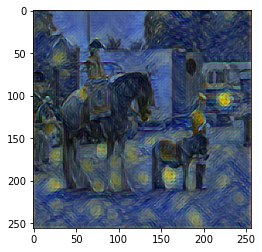

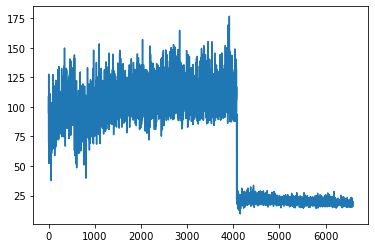

tensor(17.4376, grad_fn=<MulBackward0>)


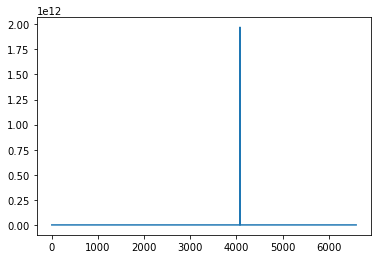

tensor(12.0633, grad_fn=<MulBackward0>)


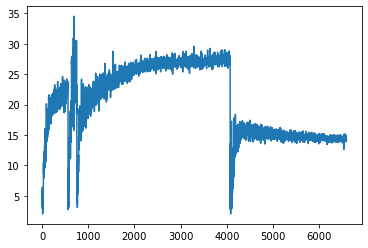

tensor(14.2416, grad_fn=<MulBackward0>)
****************************
Content Loss: 19.406171798706055
Style Loss: 9.821935653686523
Total Variation Loss: 14.334128379821777
Training Batch: 2501 Loss: 43.562237
****************************
****************************
Content Loss: 15.846915245056152
Style Loss: 10.552592277526855
Total Variation Loss: 14.055335998535156
Training Batch: 2502 Loss: 40.454842
****************************
****************************
Content Loss: 17.8179874420166
Style Loss: 11.218024253845215
Total Variation Loss: 14.486635208129883
Training Batch: 2503 Loss: 43.522644
****************************
****************************
Content Loss: 18.076120376586914
Style Loss: 10.798239707946777
Total Variation Loss: 14.631802558898926
Training Batch: 2504 Loss: 43.506161
****************************
****************************
Content Loss: 19.94232177734375
Style Loss: 14.537943840026855
Total Variation Loss: 14.122523307800293
Training Batch: 2505 Loss: 48.

****************************
Content Loss: 16.72495460510254
Style Loss: 11.170731544494629
Total Variation Loss: 14.575994491577148
Training Batch: 2542 Loss: 42.471680
****************************
****************************
Content Loss: 19.46733856201172
Style Loss: 10.603256225585938
Total Variation Loss: 14.614042282104492
Training Batch: 2543 Loss: 44.684639
****************************
****************************
Content Loss: 19.090347290039062
Style Loss: 10.114325523376465
Total Variation Loss: 14.392155647277832
Training Batch: 2544 Loss: 43.596828
****************************
****************************
Content Loss: 18.226486206054688
Style Loss: 10.690402030944824
Total Variation Loss: 14.147476196289062
Training Batch: 2545 Loss: 43.064365
****************************
****************************
Content Loss: 18.560747146606445
Style Loss: 12.744132041931152
Total Variation Loss: 13.984619140625
Training Batch: 2546 Loss: 45.289497
****************************
*****

Training Batch: 2583 Loss: 46.978928
****************************
****************************
Content Loss: 18.592769622802734
Style Loss: 16.2365779876709
Total Variation Loss: 14.112595558166504
Training Batch: 2584 Loss: 48.941940
****************************
****************************
Content Loss: 23.76718521118164
Style Loss: 11.120499610900879
Total Variation Loss: 14.612957954406738
Training Batch: 2585 Loss: 49.500641
****************************
****************************
Content Loss: 18.275060653686523
Style Loss: 11.06517219543457
Total Variation Loss: 14.491937637329102
Training Batch: 2586 Loss: 43.832169
****************************
****************************
Content Loss: 15.24187183380127
Style Loss: 11.80767822265625
Total Variation Loss: 14.843162536621094
Training Batch: 2587 Loss: 41.892712
****************************
****************************
Content Loss: 14.558489799499512
Style Loss: 10.23603630065918
Total Variation Loss: 14.529545783996582
Trainin

****************************
Content Loss: 16.09290313720703
Style Loss: 13.390960693359375
Total Variation Loss: 14.02025318145752
Training Batch: 2625 Loss: 43.504116
****************************
****************************
Content Loss: 16.824016571044922
Style Loss: 11.776196479797363
Total Variation Loss: 14.211857795715332
Training Batch: 2626 Loss: 42.812069
****************************
****************************
Content Loss: 21.505840301513672
Style Loss: 11.30889892578125
Total Variation Loss: 14.173827171325684
Training Batch: 2627 Loss: 46.988567
****************************
****************************
Content Loss: 18.057645797729492
Style Loss: 10.992301940917969
Total Variation Loss: 14.128503799438477
Training Batch: 2628 Loss: 43.178452
****************************
****************************
Content Loss: 17.09119987487793
Style Loss: 12.018238067626953
Total Variation Loss: 14.251348495483398
Training Batch: 2629 Loss: 43.360786
****************************
****

Training Batch: 2666 Loss: 45.222000
****************************
****************************
Content Loss: 23.037757873535156
Style Loss: 11.991199493408203
Total Variation Loss: 14.671745300292969
Training Batch: 2667 Loss: 49.700703
****************************
****************************
Content Loss: 17.18764877319336
Style Loss: 9.335637092590332
Total Variation Loss: 14.686322212219238
Training Batch: 2668 Loss: 41.209606
****************************
****************************
Content Loss: 20.93415069580078
Style Loss: 11.732836723327637
Total Variation Loss: 14.821660995483398
Training Batch: 2669 Loss: 47.488647
****************************
****************************
Content Loss: 19.92169189453125
Style Loss: 12.492228507995605
Total Variation Loss: 14.523606300354004
Training Batch: 2670 Loss: 46.937527
****************************
****************************
Content Loss: 17.122554779052734
Style Loss: 12.228667259216309
Total Variation Loss: 14.2122163772583
Traini

****************************
Content Loss: 21.591411590576172
Style Loss: 11.249540328979492
Total Variation Loss: 14.390707969665527
Training Batch: 2708 Loss: 47.231659
****************************
****************************
Content Loss: 16.769556045532227
Style Loss: 10.755899429321289
Total Variation Loss: 14.231147766113281
Training Batch: 2709 Loss: 41.756603
****************************
****************************
Content Loss: 16.717782974243164
Style Loss: 9.446109771728516
Total Variation Loss: 14.328343391418457
Training Batch: 2710 Loss: 40.492237
****************************
****************************
Content Loss: 16.4843692779541
Style Loss: 10.950723648071289
Total Variation Loss: 14.18478012084961
Training Batch: 2711 Loss: 41.619873
****************************
****************************
Content Loss: 22.562702178955078
Style Loss: 11.882073402404785
Total Variation Loss: 14.566269874572754
Training Batch: 2712 Loss: 49.011044
****************************
****

Training Batch: 2749 Loss: 41.214043
****************************
****************************
Content Loss: 17.064556121826172
Style Loss: 9.52241325378418
Total Variation Loss: 14.068025588989258
Training Batch: 2750 Loss: 40.654995
****************************
****************************
Content Loss: 17.382183074951172
Style Loss: 10.173169136047363
Total Variation Loss: 14.22773551940918
Training Batch: 2751 Loss: 41.783089
****************************
****************************
Content Loss: 17.096664428710938
Style Loss: 9.621407508850098
Total Variation Loss: 14.140913009643555
Training Batch: 2752 Loss: 40.858986
****************************
****************************
Content Loss: 18.077499389648438
Style Loss: 11.175860404968262
Total Variation Loss: 13.765128135681152
Training Batch: 2753 Loss: 43.018490
****************************
****************************
Content Loss: 18.074264526367188
Style Loss: 12.336915016174316
Total Variation Loss: 14.352848052978516
Trai

****************************
Content Loss: 19.832523345947266
Style Loss: 11.057074546813965
Total Variation Loss: 14.573385238647461
Training Batch: 2791 Loss: 45.462982
****************************
****************************
Content Loss: 19.74839210510254
Style Loss: 9.776769638061523
Total Variation Loss: 14.339670181274414
Training Batch: 2792 Loss: 43.864830
****************************
****************************
Content Loss: 19.31844139099121
Style Loss: 12.156451225280762
Total Variation Loss: 14.16525650024414
Training Batch: 2793 Loss: 45.640148
****************************
****************************
Content Loss: 21.643556594848633
Style Loss: 12.15246295928955
Total Variation Loss: 14.543770790100098
Training Batch: 2794 Loss: 48.339790
****************************
****************************
Content Loss: 17.970293045043945
Style Loss: 9.569709777832031
Total Variation Loss: 14.377548217773438
Training Batch: 2795 Loss: 41.917549
****************************
******

Training Batch: 2832 Loss: 39.526890
****************************
****************************
Content Loss: 19.1762638092041
Style Loss: 11.496148109436035
Total Variation Loss: 14.483282089233398
Training Batch: 2833 Loss: 45.155693
****************************
****************************
Content Loss: 18.400325775146484
Style Loss: 12.26581859588623
Total Variation Loss: 13.899886131286621
Training Batch: 2834 Loss: 44.566032
****************************
****************************
Content Loss: 18.42586898803711
Style Loss: 10.518047332763672
Total Variation Loss: 14.0514497756958
Training Batch: 2835 Loss: 42.995365
****************************
****************************
Content Loss: 18.021133422851562
Style Loss: 11.913501739501953
Total Variation Loss: 13.849101066589355
Training Batch: 2836 Loss: 43.783737
****************************
****************************
Content Loss: 15.15019416809082
Style Loss: 11.67823600769043
Total Variation Loss: 13.831968307495117
Training

****************************
Content Loss: 19.064729690551758
Style Loss: 12.240776062011719
Total Variation Loss: 14.572715759277344
Training Batch: 2874 Loss: 45.878220
****************************
****************************
Content Loss: 17.38943862915039
Style Loss: 12.297054290771484
Total Variation Loss: 14.021920204162598
Training Batch: 2875 Loss: 43.708412
****************************
****************************
Content Loss: 19.5377254486084
Style Loss: 10.189151763916016
Total Variation Loss: 14.011926651000977
Training Batch: 2876 Loss: 43.738804
****************************
****************************
Content Loss: 17.05557632446289
Style Loss: 9.758186340332031
Total Variation Loss: 13.980356216430664
Training Batch: 2877 Loss: 40.794121
****************************
****************************
Content Loss: 19.188093185424805
Style Loss: 10.649357795715332
Total Variation Loss: 14.2125825881958
Training Batch: 2878 Loss: 44.050034
****************************
*******

Training Batch: 2915 Loss: 44.039585
****************************
****************************
Content Loss: 19.28909683227539
Style Loss: 11.042485237121582
Total Variation Loss: 14.285447120666504
Training Batch: 2916 Loss: 44.617027
****************************
****************************
Content Loss: 18.56277084350586
Style Loss: 10.433527946472168
Total Variation Loss: 14.865090370178223
Training Batch: 2917 Loss: 43.861389
****************************
****************************
Content Loss: 21.608549118041992
Style Loss: 11.721317291259766
Total Variation Loss: 14.304265975952148
Training Batch: 2918 Loss: 47.634132
****************************
****************************
Content Loss: 17.98483657836914
Style Loss: 10.37315559387207
Total Variation Loss: 14.469828605651855
Training Batch: 2919 Loss: 42.827820
****************************
****************************
Content Loss: 18.01801109313965
Style Loss: 10.35538101196289
Total Variation Loss: 14.418729782104492
Traini

****************************
Content Loss: 16.26793098449707
Style Loss: 9.586624145507812
Total Variation Loss: 14.218984603881836
Training Batch: 2957 Loss: 40.073540
****************************
****************************
Content Loss: 16.95784568786621
Style Loss: 10.26284122467041
Total Variation Loss: 14.173116683959961
Training Batch: 2958 Loss: 41.393806
****************************
****************************
Content Loss: 16.278114318847656
Style Loss: 10.408628463745117
Total Variation Loss: 13.808958053588867
Training Batch: 2959 Loss: 40.495701
****************************
****************************
Content Loss: 17.921764373779297
Style Loss: 12.46456241607666
Total Variation Loss: 14.34365177154541
Training Batch: 2960 Loss: 44.729977
****************************
****************************
Content Loss: 20.642345428466797
Style Loss: 12.004161834716797
Total Variation Loss: 14.317227363586426
Training Batch: 2961 Loss: 46.963734
****************************
******

Training Batch: 2998 Loss: 43.393036
****************************
****************************
Content Loss: 18.707971572875977
Style Loss: 10.406230926513672
Total Variation Loss: 14.308815956115723
Training Batch: 2999 Loss: 43.423019
****************************
****************************
Content Loss: 19.520488739013672
Style Loss: 11.265475273132324
Total Variation Loss: 14.464041709899902
Training Batch: 3000 Loss: 45.250008
****************************


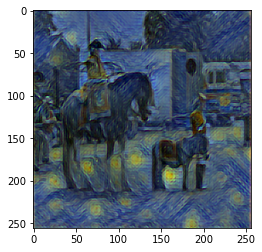

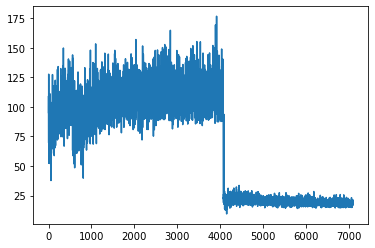

tensor(19.5205, grad_fn=<MulBackward0>)


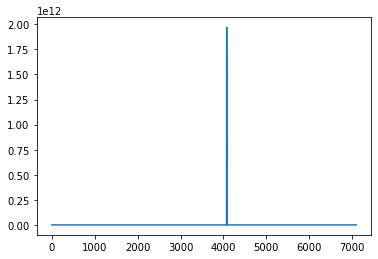

tensor(11.2655, grad_fn=<MulBackward0>)


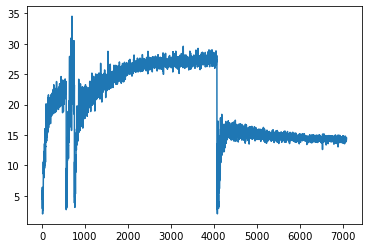

tensor(14.4640, grad_fn=<MulBackward0>)
****************************
Content Loss: 23.92723846435547
Style Loss: 10.810818672180176
Total Variation Loss: 14.441232681274414
Training Batch: 3001 Loss: 49.179291
****************************
****************************
Content Loss: 16.93100929260254
Style Loss: 12.326552391052246
Total Variation Loss: 13.890360832214355
Training Batch: 3002 Loss: 43.147923
****************************
****************************
Content Loss: 20.231979370117188
Style Loss: 9.95035171508789
Total Variation Loss: 14.378846168518066
Training Batch: 3003 Loss: 44.561176
****************************
****************************
Content Loss: 16.16718101501465
Style Loss: 10.285329818725586
Total Variation Loss: 13.891236305236816
Training Batch: 3004 Loss: 40.343746
****************************
****************************
Content Loss: 21.40909194946289
Style Loss: 10.579986572265625
Total Variation Loss: 13.89741039276123
Training Batch: 3005 Loss: 45.886

****************************
Content Loss: 16.94672966003418
Style Loss: 8.651945114135742
Total Variation Loss: 14.091645240783691
Training Batch: 3042 Loss: 39.690319
****************************
****************************
Content Loss: 16.658222198486328
Style Loss: 9.417723655700684
Total Variation Loss: 14.44736385345459
Training Batch: 3043 Loss: 40.523312
****************************
****************************
Content Loss: 19.0058536529541
Style Loss: 9.243191719055176
Total Variation Loss: 14.226776123046875
Training Batch: 3044 Loss: 42.475822
****************************
****************************
Content Loss: 17.204853057861328
Style Loss: 10.520210266113281
Total Variation Loss: 14.111763000488281
Training Batch: 3045 Loss: 41.836826
****************************
****************************
Content Loss: 18.470548629760742
Style Loss: 9.999903678894043
Total Variation Loss: 14.420992851257324
Training Batch: 3046 Loss: 42.891445
****************************
********

Training Batch: 3083 Loss: 49.091194
****************************
****************************
Content Loss: 15.72107219696045
Style Loss: 11.548114776611328
Total Variation Loss: 14.106985092163086
Training Batch: 3084 Loss: 41.376175
****************************
****************************
Content Loss: 20.607091903686523
Style Loss: 11.477001190185547
Total Variation Loss: 14.073348999023438
Training Batch: 3085 Loss: 46.157440
****************************
****************************
Content Loss: 18.564613342285156
Style Loss: 10.295553207397461
Total Variation Loss: 14.041999816894531
Training Batch: 3086 Loss: 42.902168
****************************
****************************
Content Loss: 20.987709045410156
Style Loss: 11.054363250732422
Total Variation Loss: 14.81270694732666
Training Batch: 3087 Loss: 46.854778
****************************
****************************
Content Loss: 16.08392333984375
Style Loss: 10.53115177154541
Total Variation Loss: 14.25329875946045
Train

****************************
Content Loss: 18.237417221069336
Style Loss: 10.053084373474121
Total Variation Loss: 14.458802223205566
Training Batch: 3125 Loss: 42.749302
****************************
****************************
Content Loss: 16.68347930908203
Style Loss: 9.930083274841309
Total Variation Loss: 14.11235237121582
Training Batch: 3126 Loss: 40.725914
****************************
****************************
Content Loss: 19.722015380859375
Style Loss: 9.955866813659668
Total Variation Loss: 14.281988143920898
Training Batch: 3127 Loss: 43.959869
****************************
****************************
Content Loss: 17.18871307373047
Style Loss: 11.058152198791504
Total Variation Loss: 14.32364273071289
Training Batch: 3128 Loss: 42.570507
****************************
****************************
Content Loss: 15.372406959533691
Style Loss: 9.867156982421875
Total Variation Loss: 14.133639335632324
Training Batch: 3129 Loss: 39.373203
****************************
*******

Training Batch: 3166 Loss: 47.638081
****************************
****************************
Content Loss: 20.12757110595703
Style Loss: 9.566516876220703
Total Variation Loss: 14.093646049499512
Training Batch: 3167 Loss: 43.787735
****************************
****************************
Content Loss: 18.225078582763672
Style Loss: 12.287956237792969
Total Variation Loss: 14.445968627929688
Training Batch: 3168 Loss: 44.959003
****************************
****************************
Content Loss: 18.66830825805664
Style Loss: 9.920305252075195
Total Variation Loss: 14.564666748046875
Training Batch: 3169 Loss: 43.153282
****************************
****************************
Content Loss: 18.893186569213867
Style Loss: 10.870185852050781
Total Variation Loss: 14.069571495056152
Training Batch: 3170 Loss: 43.832943
****************************
****************************
Content Loss: 18.283512115478516
Style Loss: 9.797739028930664
Total Variation Loss: 14.536930084228516
Train

****************************
Content Loss: 19.540863037109375
Style Loss: 9.706995964050293
Total Variation Loss: 14.222469329833984
Training Batch: 3208 Loss: 43.470329
****************************
****************************
Content Loss: 19.162425994873047
Style Loss: 15.912992477416992
Total Variation Loss: 13.415709495544434
Training Batch: 3209 Loss: 48.491127
****************************
****************************
Content Loss: 15.243661880493164
Style Loss: 10.568860054016113
Total Variation Loss: 14.117151260375977
Training Batch: 3210 Loss: 39.929672
****************************
****************************
Content Loss: 16.76974105834961
Style Loss: 9.2490873336792
Total Variation Loss: 14.412907600402832
Training Batch: 3211 Loss: 40.431736
****************************
****************************
Content Loss: 18.587982177734375
Style Loss: 11.203523635864258
Total Variation Loss: 14.362517356872559
Training Batch: 3212 Loss: 44.154022
****************************
*****

Training Batch: 3249 Loss: 42.956261
****************************
****************************
Content Loss: 18.050426483154297
Style Loss: 10.149175643920898
Total Variation Loss: 13.957945823669434
Training Batch: 3250 Loss: 42.157547
****************************
****************************
Content Loss: 19.937101364135742
Style Loss: 11.161556243896484
Total Variation Loss: 14.13436222076416
Training Batch: 3251 Loss: 45.233021
****************************
****************************
Content Loss: 17.723186492919922
Style Loss: 11.11034107208252
Total Variation Loss: 14.067788124084473
Training Batch: 3252 Loss: 42.901314
****************************
****************************
Content Loss: 17.20907974243164
Style Loss: 11.277420997619629
Total Variation Loss: 14.096538543701172
Training Batch: 3253 Loss: 42.583038
****************************
****************************
Content Loss: 18.617868423461914
Style Loss: 10.42642879486084
Total Variation Loss: 14.279995918273926
Trai

****************************
Content Loss: 17.52489471435547
Style Loss: 10.466376304626465
Total Variation Loss: 14.433218955993652
Training Batch: 3291 Loss: 42.424492
****************************
****************************
Content Loss: 21.21403694152832
Style Loss: 11.269194602966309
Total Variation Loss: 14.281282424926758
Training Batch: 3292 Loss: 46.764511
****************************
****************************
Content Loss: 18.429882049560547
Style Loss: 15.396886825561523
Total Variation Loss: 14.239029884338379
Training Batch: 3293 Loss: 48.065796
****************************
****************************
Content Loss: 15.773277282714844
Style Loss: 10.258888244628906
Total Variation Loss: 14.048412322998047
Training Batch: 3294 Loss: 40.080578
****************************
****************************
Content Loss: 17.391267776489258
Style Loss: 10.396733283996582
Total Variation Loss: 14.115894317626953
Training Batch: 3295 Loss: 41.903896
****************************
**

Training Batch: 3332 Loss: 50.702827
****************************
****************************
Content Loss: 19.34541130065918
Style Loss: 10.915595054626465
Total Variation Loss: 14.161504745483398
Training Batch: 3333 Loss: 44.422508
****************************
****************************
Content Loss: 20.58797836303711
Style Loss: 9.539738655090332
Total Variation Loss: 14.457612991333008
Training Batch: 3334 Loss: 44.585327
****************************
****************************
Content Loss: 17.741004943847656
Style Loss: 9.800450325012207
Total Variation Loss: 14.47786808013916
Training Batch: 3335 Loss: 42.019321
****************************
****************************
Content Loss: 16.36054801940918
Style Loss: 10.038798332214355
Total Variation Loss: 14.173337936401367
Training Batch: 3336 Loss: 40.572685
****************************
****************************
Content Loss: 15.347949028015137
Style Loss: 10.446220397949219
Total Variation Loss: 14.173788070678711
Traini

****************************
Content Loss: 16.538414001464844
Style Loss: 9.610682487487793
Total Variation Loss: 14.1489896774292
Training Batch: 3374 Loss: 40.298088
****************************
****************************
Content Loss: 16.632423400878906
Style Loss: 10.598342895507812
Total Variation Loss: 13.863362312316895
Training Batch: 3375 Loss: 41.094128
****************************
****************************
Content Loss: 18.250534057617188
Style Loss: 9.608904838562012
Total Variation Loss: 14.116394996643066
Training Batch: 3376 Loss: 41.975834
****************************
****************************
Content Loss: 16.978168487548828
Style Loss: 10.142301559448242
Total Variation Loss: 13.944793701171875
Training Batch: 3377 Loss: 41.065262
****************************
****************************
Content Loss: 18.126556396484375
Style Loss: 9.835569381713867
Total Variation Loss: 13.971028327941895
Training Batch: 3378 Loss: 41.933155
****************************
*****

Training Batch: 3415 Loss: 43.622589
****************************
****************************
Content Loss: 16.246809005737305
Style Loss: 9.655055046081543
Total Variation Loss: 14.141648292541504
Training Batch: 3416 Loss: 40.043510
****************************
****************************
Content Loss: 18.302324295043945
Style Loss: 9.765510559082031
Total Variation Loss: 14.167844772338867
Training Batch: 3417 Loss: 42.235680
****************************
****************************
Content Loss: 17.641393661499023
Style Loss: 9.363957405090332
Total Variation Loss: 14.110487937927246
Training Batch: 3418 Loss: 41.115841
****************************
****************************
Content Loss: 16.371234893798828
Style Loss: 9.456513404846191
Total Variation Loss: 13.946934700012207
Training Batch: 3419 Loss: 39.774681
****************************
****************************
Content Loss: 16.834583282470703
Style Loss: 9.722091674804688
Total Variation Loss: 13.920275688171387
Train

****************************
Content Loss: 15.316596031188965
Style Loss: 8.895895004272461
Total Variation Loss: 14.348750114440918
Training Batch: 3457 Loss: 38.561241
****************************
****************************
Content Loss: 15.610540390014648
Style Loss: 9.733176231384277
Total Variation Loss: 13.852729797363281
Training Batch: 3458 Loss: 39.196445
****************************
****************************
Content Loss: 18.475391387939453
Style Loss: 11.595362663269043
Total Variation Loss: 14.178376197814941
Training Batch: 3459 Loss: 44.249130
****************************
****************************
Content Loss: 16.409530639648438
Style Loss: 9.466591835021973
Total Variation Loss: 14.113340377807617
Training Batch: 3460 Loss: 39.989464
****************************
****************************
Content Loss: 18.5943603515625
Style Loss: 10.386431694030762
Total Variation Loss: 14.43614673614502
Training Batch: 3461 Loss: 43.416939
****************************
******

Training Batch: 3498 Loss: 43.044674
****************************
****************************
Content Loss: 17.359243392944336
Style Loss: 8.881546020507812
Total Variation Loss: 14.395365715026855
Training Batch: 3499 Loss: 40.636154
****************************
****************************
Content Loss: 19.48971939086914
Style Loss: 10.244481086730957
Total Variation Loss: 14.522279739379883
Training Batch: 3500 Loss: 44.256477
****************************


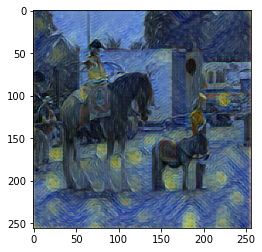

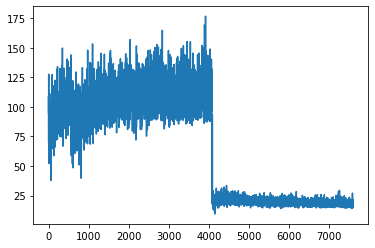

tensor(19.4897, grad_fn=<MulBackward0>)


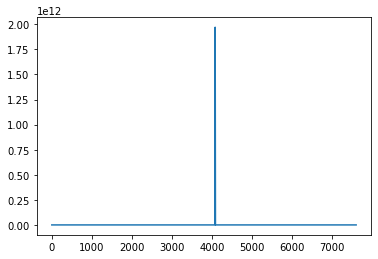

tensor(10.2445, grad_fn=<MulBackward0>)


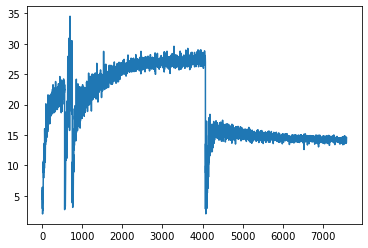

tensor(14.5223, grad_fn=<MulBackward0>)
****************************
Content Loss: 18.86906623840332
Style Loss: 10.33620834350586
Total Variation Loss: 14.338102340698242
Training Batch: 3501 Loss: 43.543377
****************************
****************************
Content Loss: 16.12189292907715
Style Loss: 8.880602836608887
Total Variation Loss: 14.077373504638672
Training Batch: 3502 Loss: 39.079868
****************************
****************************
Content Loss: 17.751331329345703
Style Loss: 9.127345085144043
Total Variation Loss: 13.991515159606934
Training Batch: 3503 Loss: 40.870193
****************************
****************************
Content Loss: 19.364015579223633
Style Loss: 9.072160720825195
Total Variation Loss: 14.44016170501709
Training Batch: 3504 Loss: 42.876339
****************************
****************************
Content Loss: 19.969253540039062
Style Loss: 9.679701805114746
Total Variation Loss: 14.225948333740234
Training Batch: 3505 Loss: 43.8749

Training Batch: 3542 Loss: 42.126972
****************************
****************************
Content Loss: 18.41805076599121
Style Loss: 10.872438430786133
Total Variation Loss: 14.392304420471191
Training Batch: 3543 Loss: 43.682793
****************************
****************************
Content Loss: 17.410259246826172
Style Loss: 10.515205383300781
Total Variation Loss: 14.189270973205566
Training Batch: 3544 Loss: 42.114735
****************************
****************************
Content Loss: 17.310245513916016
Style Loss: 11.0711030960083
Total Variation Loss: 13.885359764099121
Training Batch: 3545 Loss: 42.266708
****************************
****************************
Content Loss: 17.872108459472656
Style Loss: 9.426158905029297
Total Variation Loss: 14.145183563232422
Training Batch: 3546 Loss: 41.443451
****************************
****************************
Content Loss: 14.272655487060547
Style Loss: 10.822197914123535
Total Variation Loss: 13.612104415893555
Trai

****************************
Content Loss: 18.501052856445312
Style Loss: 11.598167419433594
Total Variation Loss: 14.13625431060791
Training Batch: 3584 Loss: 44.235474
****************************
****************************
Content Loss: 17.258325576782227
Style Loss: 10.777172088623047
Total Variation Loss: 14.069108009338379
Training Batch: 3585 Loss: 42.104607
****************************
****************************
Content Loss: 16.82219886779785
Style Loss: 9.614044189453125
Total Variation Loss: 14.180355072021484
Training Batch: 3586 Loss: 40.616600
****************************
****************************
Content Loss: 19.709976196289062
Style Loss: 8.63829231262207
Total Variation Loss: 14.340917587280273
Training Batch: 3587 Loss: 42.689186
****************************
****************************
Content Loss: 18.309202194213867
Style Loss: 9.4439115524292
Total Variation Loss: 14.279518127441406
Training Batch: 3588 Loss: 42.032631
****************************
********

Training Batch: 3625 Loss: 41.578545
****************************
****************************
Content Loss: 22.110010147094727
Style Loss: 13.913049697875977
Total Variation Loss: 14.519049644470215
Training Batch: 3626 Loss: 50.542110
****************************
****************************
Content Loss: 20.45234489440918
Style Loss: 9.598350524902344
Total Variation Loss: 14.576457977294922
Training Batch: 3627 Loss: 44.627151
****************************
****************************
Content Loss: 15.992526054382324
Style Loss: 11.28669261932373
Total Variation Loss: 14.735431671142578
Training Batch: 3628 Loss: 42.014648
****************************
****************************
Content Loss: 18.227706909179688
Style Loss: 9.628973007202148
Total Variation Loss: 14.098617553710938
Training Batch: 3629 Loss: 41.955299
****************************
****************************
Content Loss: 16.686927795410156
Style Loss: 12.411754608154297
Total Variation Loss: 14.02983283996582
Train

****************************
Content Loss: 21.152271270751953
Style Loss: 8.564610481262207
Total Variation Loss: 14.453911781311035
Training Batch: 3667 Loss: 44.170792
****************************
****************************
Content Loss: 16.093769073486328
Style Loss: 8.438828468322754
Total Variation Loss: 14.181447982788086
Training Batch: 3668 Loss: 38.714043
****************************
****************************
Content Loss: 16.056909561157227
Style Loss: 10.42587661743164
Total Variation Loss: 14.22544002532959
Training Batch: 3669 Loss: 40.708225
****************************
****************************
Content Loss: 19.12409019470215
Style Loss: 10.597064018249512
Total Variation Loss: 14.139296531677246
Training Batch: 3670 Loss: 43.860451
****************************
****************************
Content Loss: 17.632596969604492
Style Loss: 10.685569763183594
Total Variation Loss: 13.895203590393066
Training Batch: 3671 Loss: 42.213371
****************************
*****

Training Batch: 3708 Loss: 43.063114
****************************
****************************
Content Loss: 16.596738815307617
Style Loss: 10.613356590270996
Total Variation Loss: 13.835282325744629
Training Batch: 3709 Loss: 41.045376
****************************
****************************
Content Loss: 18.3847599029541
Style Loss: 9.768020629882812
Total Variation Loss: 13.846263885498047
Training Batch: 3710 Loss: 41.999046
****************************
****************************
Content Loss: 16.905780792236328
Style Loss: 10.828448295593262
Total Variation Loss: 13.792823791503906
Training Batch: 3711 Loss: 41.527054
****************************
****************************
Content Loss: 16.198776245117188
Style Loss: 9.474881172180176
Total Variation Loss: 13.75759220123291
Training Batch: 3712 Loss: 39.431248
****************************
****************************
Content Loss: 17.58415412902832
Style Loss: 10.65673542022705
Total Variation Loss: 14.324456214904785
Trainin

****************************
Content Loss: 18.85433578491211
Style Loss: 10.705118179321289
Total Variation Loss: 14.055667877197266
Training Batch: 3750 Loss: 43.615120
****************************
****************************
Content Loss: 17.56390380859375
Style Loss: 9.454358100891113
Total Variation Loss: 14.178657531738281
Training Batch: 3751 Loss: 41.196918
****************************
****************************
Content Loss: 16.917505264282227
Style Loss: 10.289058685302734
Total Variation Loss: 13.793023109436035
Training Batch: 3752 Loss: 40.999588
****************************
****************************
Content Loss: 18.744796752929688
Style Loss: 10.43033504486084
Total Variation Loss: 14.108716011047363
Training Batch: 3753 Loss: 43.283848
****************************
****************************
Content Loss: 18.00580406188965
Style Loss: 10.68624210357666
Total Variation Loss: 13.781457901000977
Training Batch: 3754 Loss: 42.473503
****************************
******

Training Batch: 3791 Loss: 38.496391
****************************
****************************
Content Loss: 17.450197219848633
Style Loss: 9.420272827148438
Total Variation Loss: 14.131905555725098
Training Batch: 3792 Loss: 41.002377
****************************
****************************
Content Loss: 14.564905166625977
Style Loss: 11.199161529541016
Total Variation Loss: 13.889182090759277
Training Batch: 3793 Loss: 39.653248
****************************
****************************
Content Loss: 18.93556785583496
Style Loss: 10.672804832458496
Total Variation Loss: 14.111917495727539
Training Batch: 3794 Loss: 43.720291
****************************
****************************
Content Loss: 19.70124053955078
Style Loss: 10.43256950378418
Total Variation Loss: 14.23255443572998
Training Batch: 3795 Loss: 44.366364
****************************
****************************
Content Loss: 18.790420532226562
Style Loss: 11.344460487365723
Total Variation Loss: 13.747441291809082
Train

****************************
Content Loss: 17.376392364501953
Style Loss: 9.581161499023438
Total Variation Loss: 14.032382011413574
Training Batch: 3833 Loss: 40.989937
****************************
****************************
Content Loss: 17.48646354675293
Style Loss: 9.382963180541992
Total Variation Loss: 14.017215728759766
Training Batch: 3834 Loss: 40.886642
****************************
****************************
Content Loss: 18.665283203125
Style Loss: 9.946600914001465
Total Variation Loss: 13.980925559997559
Training Batch: 3835 Loss: 42.592812
****************************
****************************
Content Loss: 19.155181884765625
Style Loss: 10.01987075805664
Total Variation Loss: 14.36977481842041
Training Batch: 3836 Loss: 43.544827
****************************
****************************
Content Loss: 17.249496459960938
Style Loss: 9.201034545898438
Total Variation Loss: 13.992606163024902
Training Batch: 3837 Loss: 40.443138
****************************
**********

Training Batch: 3874 Loss: 45.191544
****************************
****************************
Content Loss: 16.6143856048584
Style Loss: 10.20475959777832
Total Variation Loss: 13.826580047607422
Training Batch: 3875 Loss: 40.645725
****************************
****************************
Content Loss: 16.13477897644043
Style Loss: 12.064453125
Total Variation Loss: 13.885496139526367
Training Batch: 3876 Loss: 42.084728
****************************
****************************
Content Loss: 15.878096580505371
Style Loss: 9.602884292602539
Total Variation Loss: 14.035032272338867
Training Batch: 3877 Loss: 39.516014
****************************
****************************
Content Loss: 17.826215744018555
Style Loss: 10.740132331848145
Total Variation Loss: 14.176267623901367
Training Batch: 3878 Loss: 42.742615
****************************
****************************
Content Loss: 18.721242904663086
Style Loss: 8.730992317199707
Total Variation Loss: 14.141057968139648
Training Bat

****************************
Content Loss: 19.26325035095215
Style Loss: 8.689997673034668
Total Variation Loss: 14.17398452758789
Training Batch: 3916 Loss: 42.127232
****************************
****************************
Content Loss: 18.524213790893555
Style Loss: 8.924342155456543
Total Variation Loss: 13.78544807434082
Training Batch: 3917 Loss: 41.234001
****************************
****************************
Content Loss: 16.81926918029785
Style Loss: 10.214961051940918
Total Variation Loss: 14.091775894165039
Training Batch: 3918 Loss: 41.126007
****************************
****************************
Content Loss: 21.678070068359375
Style Loss: 11.615721702575684
Total Variation Loss: 14.309585571289062
Training Batch: 3919 Loss: 47.603378
****************************
****************************
Content Loss: 17.13329315185547
Style Loss: 9.815695762634277
Total Variation Loss: 14.037209510803223
Training Batch: 3920 Loss: 40.986198
****************************
********

Training Batch: 3957 Loss: 43.080215
****************************
****************************
Content Loss: 18.13979148864746
Style Loss: 10.304302215576172
Total Variation Loss: 14.153080940246582
Training Batch: 3958 Loss: 42.597176
****************************
****************************
Content Loss: 17.42420196533203
Style Loss: 10.386358261108398
Total Variation Loss: 13.44809627532959
Training Batch: 3959 Loss: 41.258656
****************************
****************************
Content Loss: 18.302759170532227
Style Loss: 9.41580867767334
Total Variation Loss: 13.956216812133789
Training Batch: 3960 Loss: 41.674782
****************************
****************************
Content Loss: 15.018821716308594
Style Loss: 9.064711570739746
Total Variation Loss: 13.73121166229248
Training Batch: 3961 Loss: 37.814747
****************************
****************************
Content Loss: 19.040246963500977
Style Loss: 10.035116195678711
Total Variation Loss: 13.943452835083008
Trainin

****************************
Content Loss: 15.40975284576416
Style Loss: 8.680829048156738
Total Variation Loss: 13.682917594909668
Training Batch: 3999 Loss: 37.773499
****************************
****************************
Content Loss: 21.83817481994629
Style Loss: 9.412792205810547
Total Variation Loss: 13.896295547485352
Training Batch: 4000 Loss: 45.147263
****************************


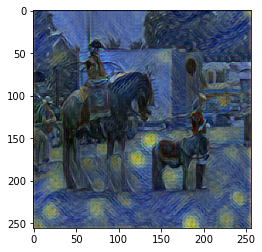

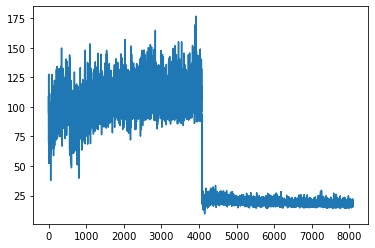

tensor(21.8382, grad_fn=<MulBackward0>)


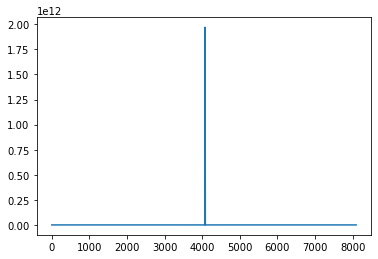

tensor(9.4128, grad_fn=<MulBackward0>)


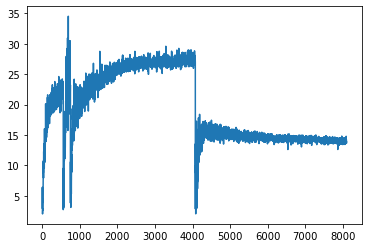

tensor(13.8963, grad_fn=<MulBackward0>)
****************************
Content Loss: 18.78509521484375
Style Loss: 9.59034538269043
Total Variation Loss: 14.12360668182373
Training Batch: 4001 Loss: 42.499046
****************************
****************************
Content Loss: 19.082124710083008
Style Loss: 10.195006370544434
Total Variation Loss: 13.7609281539917
Training Batch: 4002 Loss: 43.038059
****************************
****************************
Content Loss: 18.92097282409668
Style Loss: 10.481938362121582
Total Variation Loss: 14.048279762268066
Training Batch: 4003 Loss: 43.451191
****************************
****************************
Content Loss: 18.941129684448242
Style Loss: 10.470004081726074
Total Variation Loss: 14.319479942321777
Training Batch: 4004 Loss: 43.730614
****************************
****************************
Content Loss: 21.646644592285156
Style Loss: 11.469170570373535
Total Variation Loss: 14.273752212524414
Training Batch: 4005 Loss: 47.389

Training Batch: 4042 Loss: 42.312969
****************************
****************************
Content Loss: 14.68293285369873
Style Loss: 10.471792221069336
Total Variation Loss: 13.858413696289062
Training Batch: 4043 Loss: 39.013138
****************************
****************************
Content Loss: 19.092357635498047
Style Loss: 9.360340118408203
Total Variation Loss: 14.151351928710938
Training Batch: 4044 Loss: 42.604050
****************************
****************************
Content Loss: 18.227558135986328
Style Loss: 9.657149314880371
Total Variation Loss: 13.771074295043945
Training Batch: 4045 Loss: 41.655785
****************************
****************************
Content Loss: 20.07856559753418
Style Loss: 9.713043212890625
Total Variation Loss: 14.256230354309082
Training Batch: 4046 Loss: 44.047840
****************************
****************************
Content Loss: 17.236454010009766
Style Loss: 9.80240535736084
Total Variation Loss: 13.904275894165039
Trainin

****************************
Content Loss: 19.550743103027344
Style Loss: 9.069694519042969
Total Variation Loss: 14.233193397521973
Training Batch: 4084 Loss: 42.853630
****************************
****************************
Content Loss: 16.423534393310547
Style Loss: 9.786067962646484
Total Variation Loss: 14.151206970214844
Training Batch: 4085 Loss: 40.360809
****************************
****************************
Content Loss: 15.305158615112305
Style Loss: 10.45182991027832
Total Variation Loss: 13.608099937438965
Training Batch: 4086 Loss: 39.365089
****************************
****************************
Content Loss: 19.5396785736084
Style Loss: 10.002455711364746
Total Variation Loss: 14.273706436157227
Training Batch: 4087 Loss: 43.815842
****************************
****************************
Content Loss: 20.840301513671875
Style Loss: 10.160995483398438
Total Variation Loss: 14.283111572265625
Training Batch: 4088 Loss: 45.284409
****************************
*****

Training Batch: 4125 Loss: 40.725861
****************************
****************************
Content Loss: 16.305200576782227
Style Loss: 9.344167709350586
Total Variation Loss: 13.990860939025879
Training Batch: 4126 Loss: 39.640228
****************************
****************************
Content Loss: 18.181039810180664
Style Loss: 8.834019660949707
Total Variation Loss: 14.224440574645996
Training Batch: 4127 Loss: 41.239502
****************************
****************************
Content Loss: 18.3128662109375
Style Loss: 14.61629581451416
Total Variation Loss: 13.692770957946777
Training Batch: 4128 Loss: 46.621933
****************************
****************************
Content Loss: 16.044511795043945
Style Loss: 9.654706954956055
Total Variation Loss: 14.152624130249023
Training Batch: 4129 Loss: 39.851845
****************************
****************************
Content Loss: 16.674209594726562
Style Loss: 10.447956085205078
Total Variation Loss: 14.161752700805664
Traini

****************************
Content Loss: 18.37200164794922
Style Loss: 9.445357322692871
Total Variation Loss: 13.867193222045898
Training Batch: 4167 Loss: 41.684555
****************************
****************************
Content Loss: 17.205421447753906
Style Loss: 11.465867042541504
Total Variation Loss: 14.415162086486816
Training Batch: 4168 Loss: 43.086449
****************************
****************************
Content Loss: 13.85814094543457
Style Loss: 9.163654327392578
Total Variation Loss: 13.968855857849121
Training Batch: 4169 Loss: 36.990650
****************************
****************************
Content Loss: 16.911344528198242
Style Loss: 10.767378807067871
Total Variation Loss: 13.997941017150879
Training Batch: 4170 Loss: 41.676662
****************************
****************************
Content Loss: 17.660673141479492
Style Loss: 9.694267272949219
Total Variation Loss: 13.605879783630371
Training Batch: 4171 Loss: 40.960819
****************************
*****

Training Batch: 4208 Loss: 44.180054
****************************
****************************
Content Loss: 21.409496307373047
Style Loss: 10.764730453491211
Total Variation Loss: 14.214892387390137
Training Batch: 4209 Loss: 46.389118
****************************
****************************
Content Loss: 17.097232818603516
Style Loss: 10.126142501831055
Total Variation Loss: 14.829385757446289
Training Batch: 4210 Loss: 42.052761
****************************
****************************
Content Loss: 15.544650077819824
Style Loss: 9.49263858795166
Total Variation Loss: 14.456062316894531
Training Batch: 4211 Loss: 39.493351
****************************
****************************
Content Loss: 20.24639129638672
Style Loss: 11.152406692504883
Total Variation Loss: 13.9243803024292
Training Batch: 4212 Loss: 45.323177
****************************
****************************
Content Loss: 17.244218826293945
Style Loss: 10.442595481872559
Total Variation Loss: 13.289198875427246
Train

****************************
Content Loss: 17.59478759765625
Style Loss: 8.40424633026123
Total Variation Loss: 14.21897029876709
Training Batch: 4250 Loss: 40.218006
****************************
****************************
Content Loss: 17.670324325561523
Style Loss: 9.302495956420898
Total Variation Loss: 13.643210411071777
Training Batch: 4251 Loss: 40.616032
****************************
****************************
Content Loss: 16.21419906616211
Style Loss: 9.712713241577148
Total Variation Loss: 13.918216705322266
Training Batch: 4252 Loss: 39.845131
****************************
****************************
Content Loss: 17.062267303466797
Style Loss: 12.26267147064209
Total Variation Loss: 13.59107494354248
Training Batch: 4253 Loss: 42.916016
****************************
****************************
Content Loss: 19.412179946899414
Style Loss: 11.176762580871582
Total Variation Loss: 13.712227821350098
Training Batch: 4254 Loss: 44.301170
****************************
*********

Training Batch: 4291 Loss: 41.926556
****************************
****************************
Content Loss: 16.977380752563477
Style Loss: 8.988569259643555
Total Variation Loss: 14.04803466796875
Training Batch: 4292 Loss: 40.013985
****************************
****************************
Content Loss: 16.366540908813477
Style Loss: 8.78385066986084
Total Variation Loss: 14.327046394348145
Training Batch: 4293 Loss: 39.477436
****************************
****************************
Content Loss: 14.569417953491211
Style Loss: 8.914104461669922
Total Variation Loss: 14.024195671081543
Training Batch: 4294 Loss: 37.507717
****************************
****************************
Content Loss: 19.703502655029297
Style Loss: 10.28715991973877
Total Variation Loss: 14.08862018585205
Training Batch: 4295 Loss: 44.079281
****************************
****************************
Content Loss: 20.793581008911133
Style Loss: 10.144139289855957
Total Variation Loss: 13.632574081420898
Trainin

****************************
Content Loss: 17.68161964416504
Style Loss: 9.900153160095215
Total Variation Loss: 14.34192943572998
Training Batch: 4333 Loss: 41.923702
****************************
****************************
Content Loss: 18.18328285217285
Style Loss: 10.269220352172852
Total Variation Loss: 13.8971529006958
Training Batch: 4334 Loss: 42.349655
****************************
****************************
Content Loss: 17.888980865478516
Style Loss: 10.553875923156738
Total Variation Loss: 13.893464088439941
Training Batch: 4335 Loss: 42.336319
****************************
****************************
Content Loss: 14.579081535339355
Style Loss: 9.118186950683594
Total Variation Loss: 14.208791732788086
Training Batch: 4336 Loss: 37.906059
****************************
****************************
Content Loss: 18.51334571838379
Style Loss: 9.748414039611816
Total Variation Loss: 14.543992042541504
Training Batch: 4337 Loss: 42.805752
****************************
*********

Training Batch: 4374 Loss: 40.013237
****************************
****************************
Content Loss: 19.808700561523438
Style Loss: 11.177579879760742
Total Variation Loss: 14.179346084594727
Training Batch: 4375 Loss: 45.165627
****************************
****************************
Content Loss: 18.20227813720703
Style Loss: 10.307676315307617
Total Variation Loss: 14.022981643676758
Training Batch: 4376 Loss: 42.532936
****************************
****************************
Content Loss: 21.31386375427246
Style Loss: 9.885207176208496
Total Variation Loss: 14.222658157348633
Training Batch: 4377 Loss: 45.421730
****************************
****************************
Content Loss: 17.148441314697266
Style Loss: 9.290901184082031
Total Variation Loss: 13.542783737182617
Training Batch: 4378 Loss: 39.982124
****************************
****************************
Content Loss: 16.91702651977539
Style Loss: 8.157609939575195
Total Variation Loss: 13.879150390625
Training 

****************************
Content Loss: 18.895872116088867
Style Loss: 9.95845890045166
Total Variation Loss: 13.74057388305664
Training Batch: 4416 Loss: 42.594906
****************************
****************************
Content Loss: 18.901918411254883
Style Loss: 9.666730880737305
Total Variation Loss: 13.874112129211426
Training Batch: 4417 Loss: 42.442760
****************************
****************************
Content Loss: 17.75189971923828
Style Loss: 10.496505737304688
Total Variation Loss: 13.933433532714844
Training Batch: 4418 Loss: 42.181839
****************************
****************************
Content Loss: 18.024372100830078
Style Loss: 9.63620662689209
Total Variation Loss: 13.795489311218262
Training Batch: 4419 Loss: 41.456070
****************************
****************************
Content Loss: 21.180294036865234
Style Loss: 8.548221588134766
Total Variation Loss: 14.016368865966797
Training Batch: 4420 Loss: 43.744884
****************************
********

Training Batch: 4457 Loss: 45.197067
****************************
****************************
Content Loss: 16.770923614501953
Style Loss: 10.92500114440918
Total Variation Loss: 14.247329711914062
Training Batch: 4458 Loss: 41.943253
****************************
****************************
Content Loss: 16.16476821899414
Style Loss: 9.620138168334961
Total Variation Loss: 13.813758850097656
Training Batch: 4459 Loss: 39.598663
****************************
****************************
Content Loss: 17.822420120239258
Style Loss: 10.087634086608887
Total Variation Loss: 13.737064361572266
Training Batch: 4460 Loss: 41.647118
****************************
****************************
Content Loss: 17.71329116821289
Style Loss: 9.850776672363281
Total Variation Loss: 13.740034103393555
Training Batch: 4461 Loss: 41.304100
****************************
****************************
Content Loss: 20.95119857788086
Style Loss: 9.98328971862793
Total Variation Loss: 14.56285285949707
Training 

****************************
Content Loss: 21.771230697631836
Style Loss: 10.060400009155273
Total Variation Loss: 14.153393745422363
Training Batch: 4499 Loss: 45.985023
****************************
****************************
Content Loss: 16.900182723999023
Style Loss: 8.959534645080566
Total Variation Loss: 13.805144309997559
Training Batch: 4500 Loss: 39.664864
****************************


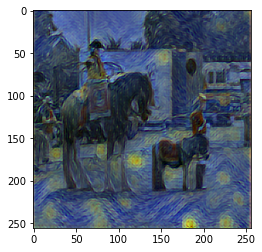

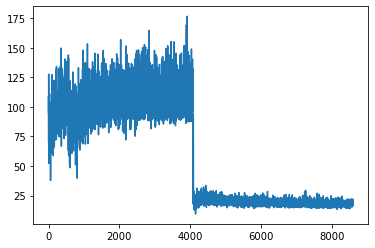

tensor(16.9002, grad_fn=<MulBackward0>)


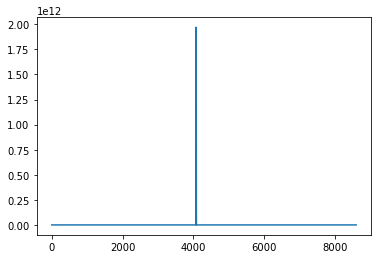

tensor(8.9595, grad_fn=<MulBackward0>)


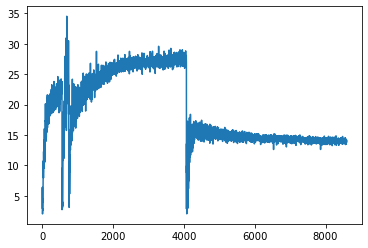

tensor(13.8051, grad_fn=<MulBackward0>)
****************************
Content Loss: 16.168912887573242
Style Loss: 9.764897346496582
Total Variation Loss: 13.739255905151367
Training Batch: 4501 Loss: 39.673065
****************************
****************************
Content Loss: 18.40917205810547
Style Loss: 9.064757347106934
Total Variation Loss: 13.890690803527832
Training Batch: 4502 Loss: 41.364620
****************************
****************************
Content Loss: 16.533222198486328
Style Loss: 8.729022026062012
Total Variation Loss: 14.302865982055664
Training Batch: 4503 Loss: 39.565109
****************************
****************************
Content Loss: 18.28406524658203
Style Loss: 10.433846473693848
Total Variation Loss: 14.362420082092285
Training Batch: 4504 Loss: 43.080330
****************************
****************************
Content Loss: 18.529888153076172
Style Loss: 11.984736442565918
Total Variation Loss: 14.037288665771484
Training Batch: 4505 Loss: 44.5

Training Batch: 4542 Loss: 37.985153
****************************
****************************
Content Loss: 15.642332077026367
Style Loss: 9.169844627380371
Total Variation Loss: 13.864042282104492
Training Batch: 4543 Loss: 38.676216
****************************
****************************
Content Loss: 15.503372192382812
Style Loss: 10.002935409545898
Total Variation Loss: 13.68254566192627
Training Batch: 4544 Loss: 39.188854
****************************
****************************
Content Loss: 18.719322204589844
Style Loss: 10.223952293395996
Total Variation Loss: 13.974647521972656
Training Batch: 4545 Loss: 42.917923
****************************
****************************
Content Loss: 16.50543212890625
Style Loss: 9.56236743927002
Total Variation Loss: 13.814478874206543
Training Batch: 4546 Loss: 39.882278
****************************
****************************
Content Loss: 17.840688705444336
Style Loss: 8.969317436218262
Total Variation Loss: 14.027844429016113
Traini

****************************
Content Loss: 18.492937088012695
Style Loss: 9.069263458251953
Total Variation Loss: 14.158599853515625
Training Batch: 4584 Loss: 41.720802
****************************
****************************
Content Loss: 21.782848358154297
Style Loss: 11.591906547546387
Total Variation Loss: 14.327777862548828
Training Batch: 4585 Loss: 47.702534
****************************
****************************
Content Loss: 16.229400634765625
Style Loss: 12.37378215789795
Total Variation Loss: 13.447286605834961
Training Batch: 4586 Loss: 42.050468
****************************
****************************
Content Loss: 14.132157325744629
Style Loss: 11.492223739624023
Total Variation Loss: 13.627257347106934
Training Batch: 4587 Loss: 39.251640
****************************
****************************
Content Loss: 21.761798858642578
Style Loss: 11.189447402954102
Total Variation Loss: 14.0111722946167
Training Batch: 4588 Loss: 46.962421
****************************
****

Training Batch: 4625 Loss: 39.470291
****************************
****************************
Content Loss: 19.536279678344727
Style Loss: 10.197673797607422
Total Variation Loss: 14.269615173339844
Training Batch: 4626 Loss: 44.003571
****************************
****************************
Content Loss: 18.840784072875977
Style Loss: 9.159187316894531
Total Variation Loss: 14.420711517333984
Training Batch: 4627 Loss: 42.420685
****************************
****************************
Content Loss: 16.83406639099121
Style Loss: 8.061026573181152
Total Variation Loss: 14.085973739624023
Training Batch: 4628 Loss: 38.981064
****************************
****************************
Content Loss: 18.342878341674805
Style Loss: 15.65883731842041
Total Variation Loss: 13.005634307861328
Training Batch: 4629 Loss: 47.007351
****************************
****************************
Content Loss: 19.351789474487305
Style Loss: 11.523114204406738
Total Variation Loss: 13.615044593811035
Trai

****************************
Content Loss: 19.17447280883789
Style Loss: 8.398280143737793
Total Variation Loss: 14.22846794128418
Training Batch: 4667 Loss: 41.801224
****************************
****************************
Content Loss: 16.080307006835938
Style Loss: 9.736828804016113
Total Variation Loss: 13.744660377502441
Training Batch: 4668 Loss: 39.561794
****************************
****************************
Content Loss: 17.131214141845703
Style Loss: 11.105018615722656
Total Variation Loss: 14.124014854431152
Training Batch: 4669 Loss: 42.360249
****************************
****************************
Content Loss: 17.734127044677734
Style Loss: 9.160208702087402
Total Variation Loss: 13.941570281982422
Training Batch: 4670 Loss: 40.835907
****************************
****************************
Content Loss: 17.477293014526367
Style Loss: 9.15109634399414
Total Variation Loss: 13.801011085510254
Training Batch: 4671 Loss: 40.429401
****************************
*******

Training Batch: 4708 Loss: 39.867027
****************************
****************************
Content Loss: 19.082717895507812
Style Loss: 10.194543838500977
Total Variation Loss: 13.90308952331543
Training Batch: 4709 Loss: 43.180351
****************************
****************************
Content Loss: 19.33132553100586
Style Loss: 9.47383975982666
Total Variation Loss: 13.905158042907715
Training Batch: 4710 Loss: 42.710323
****************************
****************************
Content Loss: 16.77768898010254
Style Loss: 8.54893970489502
Total Variation Loss: 14.235289573669434
Training Batch: 4711 Loss: 39.561920
****************************
****************************
Content Loss: 17.593994140625
Style Loss: 8.862004280090332
Total Variation Loss: 14.106293678283691
Training Batch: 4712 Loss: 40.562290
****************************
****************************
Content Loss: 16.310792922973633
Style Loss: 10.01496410369873
Total Variation Loss: 14.071228981018066
Training Bat

****************************
Content Loss: 18.813114166259766
Style Loss: 8.537053108215332
Total Variation Loss: 14.39897632598877
Training Batch: 4750 Loss: 41.749142
****************************
****************************
Content Loss: 17.431316375732422
Style Loss: 9.68263053894043
Total Variation Loss: 13.960451126098633
Training Batch: 4751 Loss: 41.074398
****************************
****************************
Content Loss: 17.546905517578125
Style Loss: 9.48268985748291
Total Variation Loss: 13.624001502990723
Training Batch: 4752 Loss: 40.653595
****************************
****************************
Content Loss: 14.647990226745605
Style Loss: 9.783166885375977
Total Variation Loss: 13.574248313903809
Training Batch: 4753 Loss: 38.005405
****************************
****************************
Content Loss: 18.086210250854492
Style Loss: 11.358052253723145
Total Variation Loss: 13.790176391601562
Training Batch: 4754 Loss: 43.234440
****************************
*******

Training Batch: 4791 Loss: 38.089260
****************************
****************************
Content Loss: 18.535741806030273
Style Loss: 9.772568702697754
Total Variation Loss: 13.97850513458252
Training Batch: 4792 Loss: 42.286816
****************************
****************************
Content Loss: 16.811603546142578
Style Loss: 8.75897216796875
Total Variation Loss: 14.05721378326416
Training Batch: 4793 Loss: 39.627789
****************************
****************************
Content Loss: 16.117948532104492
Style Loss: 10.229857444763184
Total Variation Loss: 13.693440437316895
Training Batch: 4794 Loss: 40.041245
****************************
****************************
Content Loss: 19.852367401123047
Style Loss: 10.566288948059082
Total Variation Loss: 13.971960067749023
Training Batch: 4795 Loss: 44.390617
****************************
****************************
Content Loss: 20.597673416137695
Style Loss: 9.803021430969238
Total Variation Loss: 13.857797622680664
Traini

****************************
Content Loss: 15.775131225585938
Style Loss: 9.100968360900879
Total Variation Loss: 13.725549697875977
Training Batch: 4833 Loss: 38.601646
****************************
****************************
Content Loss: 18.295387268066406
Style Loss: 10.18484878540039
Total Variation Loss: 14.154196739196777
Training Batch: 4834 Loss: 42.634434
****************************
****************************
Content Loss: 16.223756790161133
Style Loss: 9.983396530151367
Total Variation Loss: 13.88927936553955
Training Batch: 4835 Loss: 40.096432
****************************
****************************
Content Loss: 16.943267822265625
Style Loss: 9.586647033691406
Total Variation Loss: 13.751914024353027
Training Batch: 4836 Loss: 40.281830
****************************
****************************
Content Loss: 19.395282745361328
Style Loss: 9.726099014282227
Total Variation Loss: 13.91732406616211
Training Batch: 4837 Loss: 43.038704
****************************
*******

Training Batch: 4874 Loss: 41.996323
****************************
****************************
Content Loss: 16.783096313476562
Style Loss: 9.164239883422852
Total Variation Loss: 13.991111755371094
Training Batch: 4875 Loss: 39.938446
****************************
****************************
Content Loss: 17.46189308166504
Style Loss: 10.27655029296875
Total Variation Loss: 13.9342041015625
Training Batch: 4876 Loss: 41.672646
****************************
****************************
Content Loss: 14.88615608215332
Style Loss: 9.150067329406738
Total Variation Loss: 13.967743873596191
Training Batch: 4877 Loss: 38.003967
****************************
****************************
Content Loss: 17.4632511138916
Style Loss: 9.910298347473145
Total Variation Loss: 13.81477165222168
Training Batch: 4878 Loss: 41.188324
****************************
****************************
Content Loss: 17.195751190185547
Style Loss: 8.751094818115234
Total Variation Loss: 13.837127685546875
Training Bat

****************************
Content Loss: 18.33527183532715
Style Loss: 10.179959297180176
Total Variation Loss: 14.366470336914062
Training Batch: 4916 Loss: 42.881702
****************************
****************************
Content Loss: 20.374805450439453
Style Loss: 8.162567138671875
Total Variation Loss: 13.889165878295898
Training Batch: 4917 Loss: 42.426537
****************************
****************************
Content Loss: 18.525127410888672
Style Loss: 11.022316932678223
Total Variation Loss: 13.753006935119629
Training Batch: 4918 Loss: 43.300449
****************************
****************************
Content Loss: 16.167455673217773
Style Loss: 10.079232215881348
Total Variation Loss: 13.466580390930176
Training Batch: 4919 Loss: 39.713268
****************************
****************************
Content Loss: 19.171438217163086
Style Loss: 10.451617240905762
Total Variation Loss: 13.821123123168945
Training Batch: 4920 Loss: 43.444176
****************************
**

Training Batch: 4957 Loss: 40.907677
****************************
****************************
Content Loss: 16.985286712646484
Style Loss: 10.249638557434082
Total Variation Loss: 13.817299842834473
Training Batch: 4958 Loss: 41.052223
****************************
****************************
Content Loss: 13.620771408081055
Style Loss: 10.276476860046387
Total Variation Loss: 13.433642387390137
Training Batch: 4959 Loss: 37.330891
****************************
****************************
Content Loss: 18.25832176208496
Style Loss: 9.229129791259766
Total Variation Loss: 13.768632888793945
Training Batch: 4960 Loss: 41.256084
****************************
****************************
Content Loss: 17.3670711517334
Style Loss: 9.530454635620117
Total Variation Loss: 14.098135948181152
Training Batch: 4961 Loss: 40.995663
****************************
****************************
Content Loss: 20.385787963867188
Style Loss: 8.128100395202637
Total Variation Loss: 14.122591972351074
Traini

****************************
Content Loss: 17.70836639404297
Style Loss: 10.719255447387695
Total Variation Loss: 14.16650390625
Training Batch: 4999 Loss: 42.594124
****************************
****************************
Content Loss: 15.9005126953125
Style Loss: 9.404833793640137
Total Variation Loss: 14.205140113830566
Training Batch: 5000 Loss: 39.510487
****************************


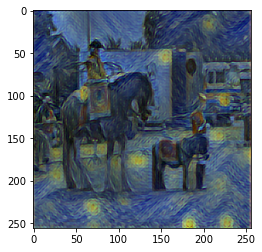

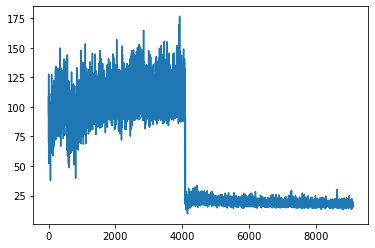

tensor(15.9005, grad_fn=<MulBackward0>)


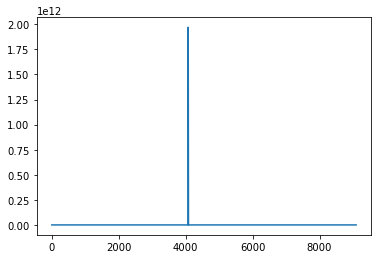

tensor(9.4048, grad_fn=<MulBackward0>)


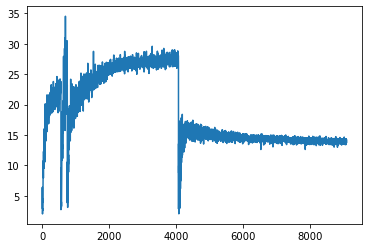

tensor(14.2051, grad_fn=<MulBackward0>)
****************************
Content Loss: 19.225297927856445
Style Loss: 10.028573036193848
Total Variation Loss: 13.988005638122559
Training Batch: 5001 Loss: 43.241879
****************************
****************************
Content Loss: 17.206052780151367
Style Loss: 8.831231117248535
Total Variation Loss: 14.135499954223633
Training Batch: 5002 Loss: 40.172783
****************************
****************************
Content Loss: 19.06059455871582
Style Loss: 10.099527359008789
Total Variation Loss: 13.727733612060547
Training Batch: 5003 Loss: 42.887856
****************************
****************************
Content Loss: 18.591903686523438
Style Loss: 8.287367820739746
Total Variation Loss: 14.501607894897461
Training Batch: 5004 Loss: 41.380882
****************************
****************************
Content Loss: 17.065393447875977
Style Loss: 9.522815704345703
Total Variation Loss: 14.174322128295898
Training Batch: 5005 Loss: 40.

Training Batch: 5042 Loss: 49.903202
****************************
****************************
Content Loss: 17.531583786010742
Style Loss: 11.754617691040039
Total Variation Loss: 13.99269962310791
Training Batch: 5043 Loss: 43.278900
****************************
****************************
Content Loss: 17.23692512512207
Style Loss: 9.602614402770996
Total Variation Loss: 13.790122032165527
Training Batch: 5044 Loss: 40.629662
****************************
****************************
Content Loss: 15.22125244140625
Style Loss: 9.947409629821777
Total Variation Loss: 14.22700023651123
Training Batch: 5045 Loss: 39.395664
****************************
****************************
Content Loss: 25.220657348632812
Style Loss: 10.635285377502441
Total Variation Loss: 14.091212272644043
Training Batch: 5046 Loss: 49.947155
****************************
****************************
Content Loss: 16.280799865722656
Style Loss: 9.183279037475586
Total Variation Loss: 14.330938339233398
Trainin

****************************
Content Loss: 17.482524871826172
Style Loss: 12.169218063354492
Total Variation Loss: 13.143963813781738
Training Batch: 5084 Loss: 42.795708
****************************
****************************
Content Loss: 18.736129760742188
Style Loss: 9.772941589355469
Total Variation Loss: 14.231865882873535
Training Batch: 5085 Loss: 42.740936
****************************
****************************
Content Loss: 17.852161407470703
Style Loss: 10.414534568786621
Total Variation Loss: 14.079322814941406
Training Batch: 5086 Loss: 42.346020
****************************
****************************
Content Loss: 16.83383560180664
Style Loss: 10.374105453491211
Total Variation Loss: 13.818984031677246
Training Batch: 5087 Loss: 41.026924
****************************
****************************
Content Loss: 16.887348175048828
Style Loss: 11.09687328338623
Total Variation Loss: 14.147126197814941
Training Batch: 5088 Loss: 42.131348
****************************
***

Training Batch: 5125 Loss: 39.636566
****************************
****************************
Content Loss: 14.343952178955078
Style Loss: 8.72298526763916
Total Variation Loss: 13.563348770141602
Training Batch: 5126 Loss: 36.630287
****************************
****************************
Content Loss: 20.50869369506836
Style Loss: 9.641180038452148
Total Variation Loss: 14.07406997680664
Training Batch: 5127 Loss: 44.223946
****************************
****************************
Content Loss: 19.440935134887695
Style Loss: 10.732763290405273
Total Variation Loss: 13.88176441192627
Training Batch: 5128 Loss: 44.055462
****************************
****************************
Content Loss: 18.165307998657227
Style Loss: 8.536930084228516
Total Variation Loss: 13.860099792480469
Training Batch: 5129 Loss: 40.562340
****************************
****************************
Content Loss: 21.915451049804688
Style Loss: 9.957385063171387
Total Variation Loss: 13.921836853027344
Training

****************************
Content Loss: 19.560802459716797
Style Loss: 10.024927139282227
Total Variation Loss: 13.72647762298584
Training Batch: 5167 Loss: 43.312206
****************************
****************************
Content Loss: 17.883705139160156
Style Loss: 8.378788948059082
Total Variation Loss: 14.134526252746582
Training Batch: 5168 Loss: 40.397018
****************************
****************************
Content Loss: 16.68180274963379
Style Loss: 8.260581970214844
Total Variation Loss: 13.996549606323242
Training Batch: 5169 Loss: 38.938934
****************************
****************************
Content Loss: 19.760440826416016
Style Loss: 8.872963905334473
Total Variation Loss: 13.685126304626465
Training Batch: 5170 Loss: 42.318531
****************************
****************************
Content Loss: 19.092666625976562
Style Loss: 10.21026611328125
Total Variation Loss: 14.125833511352539
Training Batch: 5171 Loss: 43.428764
****************************
******

Training Batch: 5208 Loss: 42.718906
****************************
****************************
Content Loss: 18.965316772460938
Style Loss: 9.110116958618164
Total Variation Loss: 14.099655151367188
Training Batch: 5209 Loss: 42.175087
****************************
****************************
Content Loss: 16.410255432128906
Style Loss: 9.896759986877441
Total Variation Loss: 14.03462028503418
Training Batch: 5210 Loss: 40.341637
****************************
****************************
Content Loss: 15.918185234069824
Style Loss: 11.11221694946289
Total Variation Loss: 14.090432167053223
Training Batch: 5211 Loss: 41.120834
****************************
****************************
Content Loss: 16.864988327026367
Style Loss: 8.53292179107666
Total Variation Loss: 14.03188705444336
Training Batch: 5212 Loss: 39.429798
****************************
****************************
Content Loss: 17.6884822845459
Style Loss: 8.64786148071289
Total Variation Loss: 14.099632263183594
Training Ba

****************************
Content Loss: 17.123188018798828
Style Loss: 9.604972839355469
Total Variation Loss: 13.812941551208496
Training Batch: 5250 Loss: 40.541103
****************************
****************************
Content Loss: 15.074021339416504
Style Loss: 8.856083869934082
Total Variation Loss: 13.572813034057617
Training Batch: 5251 Loss: 37.502918
****************************
****************************
Content Loss: 16.250947952270508
Style Loss: 10.1844482421875
Total Variation Loss: 13.55168628692627
Training Batch: 5252 Loss: 39.987083
****************************
****************************
Content Loss: 18.877416610717773
Style Loss: 8.625391960144043
Total Variation Loss: 13.86472225189209
Training Batch: 5253 Loss: 41.367531
****************************
****************************
Content Loss: 18.79677391052246
Style Loss: 8.524237632751465
Total Variation Loss: 14.052648544311523
Training Batch: 5254 Loss: 41.373657
****************************
*********

Training Batch: 5291 Loss: 41.748001
****************************
****************************
Content Loss: 17.390972137451172
Style Loss: 9.165990829467773
Total Variation Loss: 13.79606819152832
Training Batch: 5292 Loss: 40.353031
****************************
****************************
Content Loss: 16.374942779541016
Style Loss: 8.743673324584961
Total Variation Loss: 14.091429710388184
Training Batch: 5293 Loss: 39.210045
****************************
****************************
Content Loss: 16.012407302856445
Style Loss: 9.755621910095215
Total Variation Loss: 13.794499397277832
Training Batch: 5294 Loss: 39.562527
****************************
****************************
Content Loss: 17.38141632080078
Style Loss: 9.220735549926758
Total Variation Loss: 14.188488960266113
Training Batch: 5295 Loss: 40.790642
****************************
****************************
Content Loss: 20.10659408569336
Style Loss: 9.817954063415527
Total Variation Loss: 13.902194023132324
Training

****************************
Content Loss: 16.761680603027344
Style Loss: 9.20946216583252
Total Variation Loss: 13.905820846557617
Training Batch: 5333 Loss: 39.876961
****************************
****************************
Content Loss: 17.70181655883789
Style Loss: 9.075531005859375
Total Variation Loss: 13.813030242919922
Training Batch: 5334 Loss: 40.590378
****************************
****************************
Content Loss: 19.225065231323242
Style Loss: 9.145548820495605
Total Variation Loss: 13.951677322387695
Training Batch: 5335 Loss: 42.322289
****************************
****************************
Content Loss: 15.94365406036377
Style Loss: 9.509700775146484
Total Variation Loss: 13.721793174743652
Training Batch: 5336 Loss: 39.175148
****************************
****************************
Content Loss: 16.9012393951416
Style Loss: 10.245162963867188
Total Variation Loss: 14.036846160888672
Training Batch: 5337 Loss: 41.183250
****************************
*********

Training Batch: 5374 Loss: 43.114944
****************************
****************************
Content Loss: 16.975852966308594
Style Loss: 9.370614051818848
Total Variation Loss: 13.68226432800293
Training Batch: 5375 Loss: 40.028732
****************************
****************************
Content Loss: 18.9367733001709
Style Loss: 9.77609920501709
Total Variation Loss: 13.83305549621582
Training Batch: 5376 Loss: 42.545929
****************************
****************************
Content Loss: 19.80377769470215
Style Loss: 11.288726806640625
Total Variation Loss: 13.460847854614258
Training Batch: 5377 Loss: 44.553352
****************************
****************************
Content Loss: 15.426368713378906
Style Loss: 8.672411918640137
Total Variation Loss: 13.60390567779541
Training Batch: 5378 Loss: 37.702686
****************************
****************************
Content Loss: 17.244558334350586
Style Loss: 8.589634895324707
Total Variation Loss: 13.779601097106934
Training Ba

****************************
Content Loss: 21.146211624145508
Style Loss: 12.82125186920166
Total Variation Loss: 13.928892135620117
Training Batch: 5416 Loss: 47.896355
****************************
****************************
Content Loss: 15.223478317260742
Style Loss: 10.589980125427246
Total Variation Loss: 14.132325172424316
Training Batch: 5417 Loss: 39.945782
****************************
****************************
Content Loss: 16.85470199584961
Style Loss: 8.756293296813965
Total Variation Loss: 14.044048309326172
Training Batch: 5418 Loss: 39.655045
****************************
****************************
Content Loss: 15.697284698486328
Style Loss: 9.237966537475586
Total Variation Loss: 13.687642097473145
Training Batch: 5419 Loss: 38.622894
****************************
****************************
Content Loss: 21.317447662353516
Style Loss: 9.218999862670898
Total Variation Loss: 14.109479904174805
Training Batch: 5420 Loss: 44.645927
****************************
*****

Training Batch: 5457 Loss: 41.288696
****************************
****************************
Content Loss: 15.227787017822266
Style Loss: 9.530263900756836
Total Variation Loss: 13.592592239379883
Training Batch: 5458 Loss: 38.350643
****************************
****************************
Content Loss: 16.27597427368164
Style Loss: 10.1483154296875
Total Variation Loss: 13.90028190612793
Training Batch: 5459 Loss: 40.324570
****************************
****************************
Content Loss: 23.18345832824707
Style Loss: 10.513313293457031
Total Variation Loss: 13.806551933288574
Training Batch: 5460 Loss: 47.503323
****************************
****************************
Content Loss: 17.383392333984375
Style Loss: 9.429350852966309
Total Variation Loss: 14.225290298461914
Training Batch: 5461 Loss: 41.038033
****************************
****************************
Content Loss: 15.79503059387207
Style Loss: 11.15924072265625
Total Variation Loss: 13.535969734191895
Training 

****************************
Content Loss: 17.259387969970703
Style Loss: 10.534154891967773
Total Variation Loss: 13.78840160369873
Training Batch: 5499 Loss: 41.581944
****************************
****************************
Content Loss: 18.760433197021484
Style Loss: 9.292229652404785
Total Variation Loss: 13.557943344116211
Training Batch: 5500 Loss: 41.610603
****************************


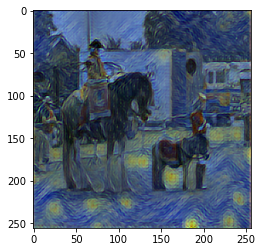

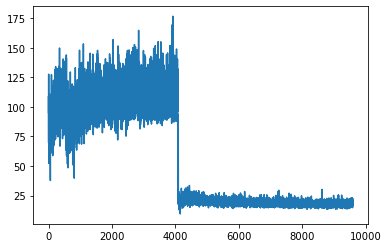

tensor(18.7604, grad_fn=<MulBackward0>)


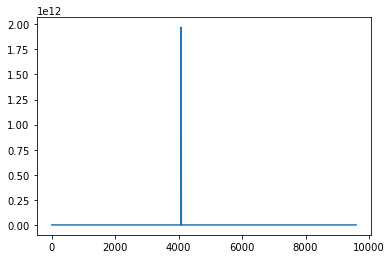

tensor(9.2922, grad_fn=<MulBackward0>)


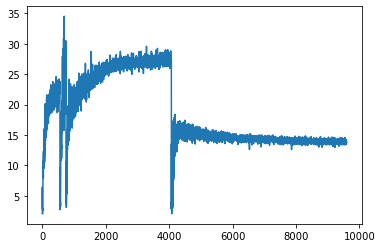

tensor(13.5579, grad_fn=<MulBackward0>)
****************************
Content Loss: 16.13022232055664
Style Loss: 9.008939743041992
Total Variation Loss: 13.937088012695312
Training Batch: 5501 Loss: 39.076248
****************************
****************************
Content Loss: 20.427692413330078
Style Loss: 9.075803756713867
Total Variation Loss: 14.32470417022705
Training Batch: 5502 Loss: 43.828201
****************************
****************************
Content Loss: 16.202966690063477
Style Loss: 9.744929313659668
Total Variation Loss: 13.876086235046387
Training Batch: 5503 Loss: 39.823982
****************************
****************************
Content Loss: 17.896297454833984
Style Loss: 8.723968505859375
Total Variation Loss: 14.291257858276367
Training Batch: 5504 Loss: 40.911522
****************************
****************************
Content Loss: 20.2357177734375
Style Loss: 8.592768669128418
Total Variation Loss: 14.145583152770996
Training Batch: 5505 Loss: 42.97407

Training Batch: 5542 Loss: 39.953804
****************************
****************************
Content Loss: 14.886316299438477
Style Loss: 10.724773406982422
Total Variation Loss: 13.880851745605469
Training Batch: 5543 Loss: 39.491943
****************************
****************************
Content Loss: 18.150245666503906
Style Loss: 11.323864936828613
Total Variation Loss: 13.875880241394043
Training Batch: 5544 Loss: 43.349991
****************************
****************************
Content Loss: 18.852001190185547
Style Loss: 9.38245677947998
Total Variation Loss: 13.73188591003418
Training Batch: 5545 Loss: 41.966347
****************************
****************************
Content Loss: 18.039566040039062
Style Loss: 10.866975784301758
Total Variation Loss: 13.96052360534668
Training Batch: 5546 Loss: 42.867065
****************************
****************************
Content Loss: 16.06422996520996
Style Loss: 9.116125106811523
Total Variation Loss: 13.988938331604004
Traini

****************************
Content Loss: 19.023426055908203
Style Loss: 10.073371887207031
Total Variation Loss: 13.950200080871582
Training Batch: 5584 Loss: 43.046997
****************************
****************************
Content Loss: 16.57853126525879
Style Loss: 10.565177917480469
Total Variation Loss: 13.932618141174316
Training Batch: 5585 Loss: 41.076328
****************************
****************************
Content Loss: 18.253568649291992
Style Loss: 9.206347465515137
Total Variation Loss: 14.0795259475708
Training Batch: 5586 Loss: 41.539440
****************************
****************************
Content Loss: 16.250003814697266
Style Loss: 10.036643981933594
Total Variation Loss: 14.124438285827637
Training Batch: 5587 Loss: 40.411087
****************************
****************************
Content Loss: 18.75453758239746
Style Loss: 8.40386962890625
Total Variation Loss: 14.15831184387207
Training Batch: 5588 Loss: 41.316719
****************************
********

Training Batch: 5625 Loss: 39.589951
****************************
****************************
Content Loss: 18.805252075195312
Style Loss: 9.116633415222168
Total Variation Loss: 14.122076034545898
Training Batch: 5626 Loss: 42.043961
****************************
****************************
Content Loss: 17.587404251098633
Style Loss: 9.618268013000488
Total Variation Loss: 13.943371772766113
Training Batch: 5627 Loss: 41.149044
****************************
****************************
Content Loss: 20.00090789794922
Style Loss: 9.17092227935791
Total Variation Loss: 13.940500259399414
Training Batch: 5628 Loss: 43.112328
****************************
****************************
Content Loss: 16.724424362182617
Style Loss: 9.271076202392578
Total Variation Loss: 13.573509216308594
Training Batch: 5629 Loss: 39.569008
****************************
****************************
Content Loss: 17.326820373535156
Style Loss: 9.199487686157227
Total Variation Loss: 13.87983512878418
Training

****************************
Content Loss: 20.957611083984375
Style Loss: 12.927757263183594
Total Variation Loss: 14.072389602661133
Training Batch: 5667 Loss: 47.957756
****************************
****************************
Content Loss: 18.463306427001953
Style Loss: 10.704289436340332
Total Variation Loss: 13.595589637756348
Training Batch: 5668 Loss: 42.763184
****************************
****************************
Content Loss: 18.265745162963867
Style Loss: 9.32386302947998
Total Variation Loss: 13.861510276794434
Training Batch: 5669 Loss: 41.451118
****************************
****************************
Content Loss: 17.36405372619629
Style Loss: 9.875628471374512
Total Variation Loss: 13.69108772277832
Training Batch: 5670 Loss: 40.930771
****************************
****************************
Content Loss: 18.133760452270508
Style Loss: 9.076488494873047
Total Variation Loss: 13.741986274719238
Training Batch: 5671 Loss: 40.952236
****************************
******

Training Batch: 5708 Loss: 42.455620
****************************
****************************
Content Loss: 18.282428741455078
Style Loss: 9.304200172424316
Total Variation Loss: 14.091279983520508
Training Batch: 5709 Loss: 41.677910
****************************
****************************
Content Loss: 20.399131774902344
Style Loss: 9.697614669799805
Total Variation Loss: 14.327012062072754
Training Batch: 5710 Loss: 44.423759
****************************
****************************
Content Loss: 17.479299545288086
Style Loss: 9.920967102050781
Total Variation Loss: 13.375909805297852
Training Batch: 5711 Loss: 40.776176
****************************
****************************
Content Loss: 19.005393981933594
Style Loss: 9.826544761657715
Total Variation Loss: 13.931048393249512
Training Batch: 5712 Loss: 42.762989
****************************
****************************
Content Loss: 16.2274169921875
Style Loss: 10.644760131835938
Total Variation Loss: 13.654631614685059
Traini

****************************
Content Loss: 19.430444717407227
Style Loss: 8.996438026428223
Total Variation Loss: 14.061657905578613
Training Batch: 5750 Loss: 42.488541
****************************
****************************
Content Loss: 18.74546241760254
Style Loss: 9.806449890136719
Total Variation Loss: 13.783062934875488
Training Batch: 5751 Loss: 42.334976
****************************
****************************
Content Loss: 20.51985740661621
Style Loss: 9.834320068359375
Total Variation Loss: 14.07236385345459
Training Batch: 5752 Loss: 44.426540
****************************
****************************
Content Loss: 16.587759017944336
Style Loss: 8.427787780761719
Total Variation Loss: 13.769887924194336
Training Batch: 5753 Loss: 38.785435
****************************
****************************
Content Loss: 16.995908737182617
Style Loss: 9.026416778564453
Total Variation Loss: 14.103887557983398
Training Batch: 5754 Loss: 40.126213
****************************
********

Training Batch: 5791 Loss: 39.869602
****************************
****************************
Content Loss: 17.26245880126953
Style Loss: 10.672551155090332
Total Variation Loss: 14.044032096862793
Training Batch: 5792 Loss: 41.979042
****************************
****************************
Content Loss: 17.05846405029297
Style Loss: 9.030452728271484
Total Variation Loss: 13.791153907775879
Training Batch: 5793 Loss: 39.880070
****************************
****************************
Content Loss: 17.616430282592773
Style Loss: 9.52845287322998
Total Variation Loss: 13.933981895446777
Training Batch: 5794 Loss: 41.078865
****************************
****************************
Content Loss: 19.337848663330078
Style Loss: 10.827722549438477
Total Variation Loss: 13.758466720581055
Training Batch: 5795 Loss: 43.924038
****************************
****************************
Content Loss: 17.487401962280273
Style Loss: 8.446109771728516
Total Variation Loss: 14.017413139343262
Traini

****************************
Content Loss: 17.503416061401367
Style Loss: 9.603641510009766
Total Variation Loss: 13.578532218933105
Training Batch: 5833 Loss: 40.685589
****************************
****************************
Content Loss: 16.223861694335938
Style Loss: 8.645938873291016
Total Variation Loss: 13.629159927368164
Training Batch: 5834 Loss: 38.498962
****************************
****************************
Content Loss: 18.344675064086914
Style Loss: 8.545873641967773
Total Variation Loss: 14.034491539001465
Training Batch: 5835 Loss: 40.925041
****************************
****************************
Content Loss: 16.77937889099121
Style Loss: 9.283559799194336
Total Variation Loss: 13.999323844909668
Training Batch: 5836 Loss: 40.062263
****************************
****************************
Content Loss: 15.183229446411133
Style Loss: 8.690868377685547
Total Variation Loss: 13.534923553466797
Training Batch: 5837 Loss: 37.409019
****************************
******

Training Batch: 5874 Loss: 43.933662
****************************
****************************
Content Loss: 15.669492721557617
Style Loss: 9.95627212524414
Total Variation Loss: 14.128308296203613
Training Batch: 5875 Loss: 39.754074
****************************
****************************
Content Loss: 16.15076446533203
Style Loss: 8.585710525512695
Total Variation Loss: 13.885778427124023
Training Batch: 5876 Loss: 38.622253
****************************
****************************
Content Loss: 18.722543716430664
Style Loss: 10.442495346069336
Total Variation Loss: 14.15590763092041
Training Batch: 5877 Loss: 43.320946
****************************
****************************
Content Loss: 17.674901962280273
Style Loss: 9.080140113830566
Total Variation Loss: 13.851156234741211
Training Batch: 5878 Loss: 40.606201
****************************
****************************
Content Loss: 17.248023986816406
Style Loss: 9.211991310119629
Total Variation Loss: 13.97400188446045
Training

****************************
Content Loss: 15.191346168518066
Style Loss: 8.544673919677734
Total Variation Loss: 13.58228588104248
Training Batch: 5916 Loss: 37.318306
****************************
****************************
Content Loss: 20.977195739746094
Style Loss: 9.12060260772705
Total Variation Loss: 13.77817440032959
Training Batch: 5917 Loss: 43.875973
****************************
****************************
Content Loss: 20.643310546875
Style Loss: 9.59848403930664
Total Variation Loss: 14.105813980102539
Training Batch: 5918 Loss: 44.347610
****************************
****************************
Content Loss: 18.486143112182617
Style Loss: 8.509819030761719
Total Variation Loss: 13.892834663391113
Training Batch: 5919 Loss: 40.888798
****************************
****************************
Content Loss: 15.863926887512207
Style Loss: 8.221267700195312
Total Variation Loss: 13.756704330444336
Training Batch: 5920 Loss: 37.841896
****************************
************

Training Batch: 5957 Loss: 42.050117
****************************
****************************
Content Loss: 17.19843864440918
Style Loss: 10.60441780090332
Total Variation Loss: 13.93215560913086
Training Batch: 5958 Loss: 41.735012
****************************
****************************
Content Loss: 20.27007293701172
Style Loss: 8.901973724365234
Total Variation Loss: 14.18375015258789
Training Batch: 5959 Loss: 43.355797
****************************
****************************
Content Loss: 17.028579711914062
Style Loss: 9.042236328125
Total Variation Loss: 14.36396598815918
Training Batch: 5960 Loss: 40.434784
****************************
****************************
Content Loss: 17.123559951782227
Style Loss: 9.771397590637207
Total Variation Loss: 13.873747825622559
Training Batch: 5961 Loss: 40.768707
****************************
****************************
Content Loss: 17.522541046142578
Style Loss: 9.425803184509277
Total Variation Loss: 13.797831535339355
Training Batc

****************************
Content Loss: 20.275644302368164
Style Loss: 8.899935722351074
Total Variation Loss: 13.91710090637207
Training Batch: 5999 Loss: 43.092682
****************************
****************************
Content Loss: 16.41008949279785
Style Loss: 8.181443214416504
Total Variation Loss: 13.704463958740234
Training Batch: 6000 Loss: 38.295998
****************************


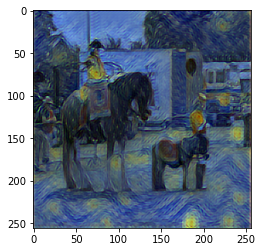

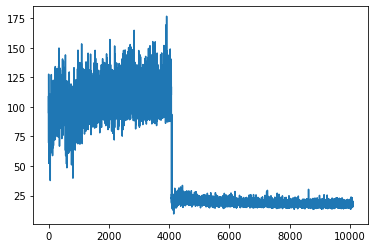

tensor(16.4101, grad_fn=<MulBackward0>)


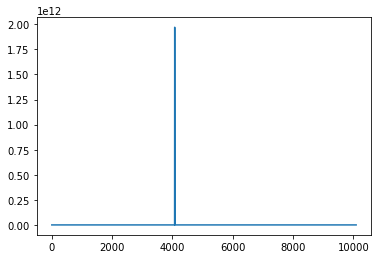

tensor(8.1814, grad_fn=<MulBackward0>)


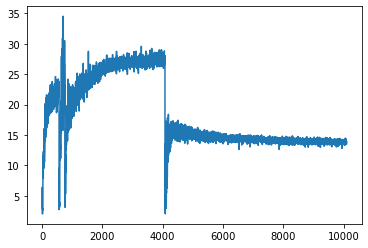

tensor(13.7045, grad_fn=<MulBackward0>)
****************************
Content Loss: 20.65596580505371
Style Loss: 11.041546821594238
Total Variation Loss: 13.730084419250488
Training Batch: 6001 Loss: 45.427597
****************************
****************************
Content Loss: 20.4628849029541
Style Loss: 9.403159141540527
Total Variation Loss: 13.979496002197266
Training Batch: 6002 Loss: 43.845539
****************************
****************************
Content Loss: 13.295365333557129
Style Loss: 9.562114715576172
Total Variation Loss: 13.109877586364746
Training Batch: 6003 Loss: 35.967358
****************************
****************************
Content Loss: 17.502540588378906
Style Loss: 9.504411697387695
Total Variation Loss: 13.667630195617676
Training Batch: 6004 Loss: 40.674583
****************************
****************************
Content Loss: 18.33928108215332
Style Loss: 10.388448715209961
Total Variation Loss: 13.43671989440918
Training Batch: 6005 Loss: 42.1644

Training Batch: 6042 Loss: 43.907444
****************************
****************************
Content Loss: 18.53636932373047
Style Loss: 11.03489875793457
Total Variation Loss: 13.812339782714844
Training Batch: 6043 Loss: 43.383606
****************************
****************************
Content Loss: 16.635454177856445
Style Loss: 12.577326774597168
Total Variation Loss: 13.383132934570312
Training Batch: 6044 Loss: 42.595913
****************************
****************************
Content Loss: 15.113316535949707
Style Loss: 9.618675231933594
Total Variation Loss: 13.807575225830078
Training Batch: 6045 Loss: 38.539566
****************************
****************************
Content Loss: 19.886974334716797
Style Loss: 9.737807273864746
Total Variation Loss: 13.904516220092773
Training Batch: 6046 Loss: 43.529297
****************************
****************************
Content Loss: 17.8912353515625
Style Loss: 8.921852111816406
Total Variation Loss: 13.835540771484375
Trainin

****************************
Content Loss: 17.69869041442871
Style Loss: 8.388912200927734
Total Variation Loss: 13.914194107055664
Training Batch: 6084 Loss: 40.001797
****************************
****************************
Content Loss: 18.294288635253906
Style Loss: 9.672377586364746
Total Variation Loss: 14.0801362991333
Training Batch: 6085 Loss: 42.046803
****************************
****************************
Content Loss: 21.714004516601562
Style Loss: 9.882356643676758
Total Variation Loss: 13.756385803222656
Training Batch: 6086 Loss: 45.352745
****************************
****************************
Content Loss: 15.579468727111816
Style Loss: 10.317312240600586
Total Variation Loss: 13.703045845031738
Training Batch: 6087 Loss: 39.599827
****************************
****************************
Content Loss: 16.06801986694336
Style Loss: 7.858838081359863
Total Variation Loss: 13.841207504272461
Training Batch: 6088 Loss: 37.768066
****************************
********

Training Batch: 6125 Loss: 39.007195
****************************
****************************
Content Loss: 19.191112518310547
Style Loss: 9.549341201782227
Total Variation Loss: 13.877503395080566
Training Batch: 6126 Loss: 42.617958
****************************
****************************
Content Loss: 18.43533706665039
Style Loss: 11.192283630371094
Total Variation Loss: 13.692627906799316
Training Batch: 6127 Loss: 43.320248
****************************
****************************
Content Loss: 14.893379211425781
Style Loss: 11.5877046585083
Total Variation Loss: 13.141355514526367
Training Batch: 6128 Loss: 39.622437
****************************
****************************
Content Loss: 18.287025451660156
Style Loss: 10.775432586669922
Total Variation Loss: 13.576233863830566
Training Batch: 6129 Loss: 42.638691
****************************
****************************
Content Loss: 17.798744201660156
Style Loss: 8.630104064941406
Total Variation Loss: 14.208826065063477
Train

****************************
Content Loss: 13.543664932250977
Style Loss: 8.374551773071289
Total Variation Loss: 13.89932918548584
Training Batch: 6167 Loss: 35.817547
****************************
****************************
Content Loss: 15.383060455322266
Style Loss: 9.712335586547852
Total Variation Loss: 13.712444305419922
Training Batch: 6168 Loss: 38.807838
****************************
****************************
Content Loss: 18.295366287231445
Style Loss: 11.973217964172363
Total Variation Loss: 13.411286354064941
Training Batch: 6169 Loss: 43.679871
****************************
****************************
Content Loss: 14.98273754119873
Style Loss: 8.27318000793457
Total Variation Loss: 13.61367416381836
Training Batch: 6170 Loss: 36.869591
****************************
****************************
Content Loss: 17.197965621948242
Style Loss: 11.04979419708252
Total Variation Loss: 13.778116226196289
Training Batch: 6171 Loss: 42.025879
****************************
********

Training Batch: 6208 Loss: 39.394623
****************************
****************************
Content Loss: 18.09697723388672
Style Loss: 9.1299409866333
Total Variation Loss: 13.863513946533203
Training Batch: 6209 Loss: 41.090431
****************************
****************************
Content Loss: 19.971628189086914
Style Loss: 9.551833152770996
Total Variation Loss: 13.834294319152832
Training Batch: 6210 Loss: 43.357754
****************************
****************************
Content Loss: 18.273103713989258
Style Loss: 11.041829109191895
Total Variation Loss: 13.53262996673584
Training Batch: 6211 Loss: 42.847565
****************************
****************************
Content Loss: 15.750871658325195
Style Loss: 9.336421012878418
Total Variation Loss: 13.694432258605957
Training Batch: 6212 Loss: 38.781723
****************************
****************************
Content Loss: 17.077999114990234
Style Loss: 10.811735153198242
Total Variation Loss: 13.524822235107422
Trainin

****************************
Content Loss: 17.767005920410156
Style Loss: 9.446895599365234
Total Variation Loss: 13.91757869720459
Training Batch: 6250 Loss: 41.131481
****************************
****************************
Content Loss: 17.060325622558594
Style Loss: 9.516433715820312
Total Variation Loss: 13.831966400146484
Training Batch: 6251 Loss: 40.408726
****************************
****************************
Content Loss: 16.075401306152344
Style Loss: 10.596846580505371
Total Variation Loss: 13.621559143066406
Training Batch: 6252 Loss: 40.293808
****************************
****************************
Content Loss: 16.36367416381836
Style Loss: 11.88853645324707
Total Variation Loss: 13.90709400177002
Training Batch: 6253 Loss: 42.159306
****************************
****************************
Content Loss: 15.631274223327637
Style Loss: 8.899950981140137
Total Variation Loss: 13.98474407196045
Training Batch: 6254 Loss: 38.515968
****************************
********

Training Batch: 6291 Loss: 41.377872
****************************
****************************
Content Loss: 19.166149139404297
Style Loss: 10.775558471679688
Total Variation Loss: 13.688755989074707
Training Batch: 6292 Loss: 43.630463
****************************
****************************
Content Loss: 19.202896118164062
Style Loss: 8.841039657592773
Total Variation Loss: 13.904067993164062
Training Batch: 6293 Loss: 41.948006
****************************
****************************
Content Loss: 14.980853080749512
Style Loss: 9.588178634643555
Total Variation Loss: 13.418476104736328
Training Batch: 6294 Loss: 37.987507
****************************
****************************
Content Loss: 17.516672134399414
Style Loss: 13.388949394226074
Total Variation Loss: 13.361776351928711
Training Batch: 6295 Loss: 44.267395
****************************
****************************
Content Loss: 19.310848236083984
Style Loss: 11.95142936706543
Total Variation Loss: 14.346819877624512
Tra

****************************
Content Loss: 16.887588500976562
Style Loss: 10.349498748779297
Total Variation Loss: 13.723504066467285
Training Batch: 6333 Loss: 40.960590
****************************
****************************
Content Loss: 15.974226951599121
Style Loss: 9.422343254089355
Total Variation Loss: 13.637271881103516
Training Batch: 6334 Loss: 39.033844
****************************
****************************
Content Loss: 20.024457931518555
Style Loss: 10.72758960723877
Total Variation Loss: 14.006314277648926
Training Batch: 6335 Loss: 44.758362
****************************
****************************
Content Loss: 21.47429656982422
Style Loss: 9.104157447814941
Total Variation Loss: 14.129317283630371
Training Batch: 6336 Loss: 44.707771
****************************
****************************
Content Loss: 18.875198364257812
Style Loss: 10.013016700744629
Total Variation Loss: 14.011884689331055
Training Batch: 6337 Loss: 42.900101
****************************
****

Training Batch: 6374 Loss: 43.441772
****************************
****************************
Content Loss: 17.918190002441406
Style Loss: 8.820284843444824
Total Variation Loss: 14.383013725280762
Training Batch: 6375 Loss: 41.121490
****************************
****************************
Content Loss: 18.856420516967773
Style Loss: 9.426396369934082
Total Variation Loss: 14.046791076660156
Training Batch: 6376 Loss: 42.329609
****************************
****************************
Content Loss: 16.79743766784668
Style Loss: 11.358444213867188
Total Variation Loss: 13.522438049316406
Training Batch: 6377 Loss: 41.678322
****************************
****************************
Content Loss: 16.154491424560547
Style Loss: 9.510942459106445
Total Variation Loss: 13.774195671081543
Training Batch: 6378 Loss: 39.439629
****************************
****************************
Content Loss: 15.986957550048828
Style Loss: 10.506032943725586
Total Variation Loss: 13.465944290161133
Trai

****************************
Content Loss: 18.49173355102539
Style Loss: 9.300219535827637
Total Variation Loss: 13.866214752197266
Training Batch: 6416 Loss: 41.658169
****************************
****************************
Content Loss: 17.462501525878906
Style Loss: 8.638556480407715
Total Variation Loss: 14.346467971801758
Training Batch: 6417 Loss: 40.447525
****************************
****************************
Content Loss: 19.537412643432617
Style Loss: 7.92852258682251
Total Variation Loss: 14.226920127868652
Training Batch: 6418 Loss: 41.692856
****************************
****************************
Content Loss: 18.019428253173828
Style Loss: 10.571135520935059
Total Variation Loss: 14.123574256896973
Training Batch: 6419 Loss: 42.714138
****************************
****************************
Content Loss: 14.945337295532227
Style Loss: 9.709270477294922
Total Variation Loss: 13.976767539978027
Training Batch: 6420 Loss: 38.631374
****************************
******

Training Batch: 6457 Loss: 40.007397
****************************
****************************
Content Loss: 14.48913860321045
Style Loss: 8.812727928161621
Total Variation Loss: 13.821582794189453
Training Batch: 6458 Loss: 37.123451
****************************
****************************
Content Loss: 18.139652252197266
Style Loss: 10.50316047668457
Total Variation Loss: 13.816020011901855
Training Batch: 6459 Loss: 42.458832
****************************
****************************
Content Loss: 14.876748085021973
Style Loss: 9.938745498657227
Total Variation Loss: 13.816593170166016
Training Batch: 6460 Loss: 38.632088
****************************
****************************
Content Loss: 15.60561752319336
Style Loss: 8.478848457336426
Total Variation Loss: 13.702812194824219
Training Batch: 6461 Loss: 37.787277
****************************
****************************
Content Loss: 14.284015655517578
Style Loss: 8.399417877197266
Total Variation Loss: 13.946512222290039
Trainin

****************************
Content Loss: 20.029020309448242
Style Loss: 9.058178901672363
Total Variation Loss: 13.67887020111084
Training Batch: 6499 Loss: 42.766071
****************************
****************************
Content Loss: 14.64128589630127
Style Loss: 11.056879997253418
Total Variation Loss: 13.598502159118652
Training Batch: 6500 Loss: 39.296669
****************************


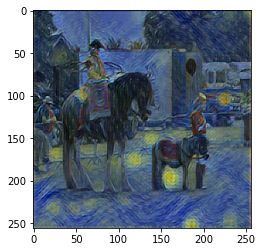

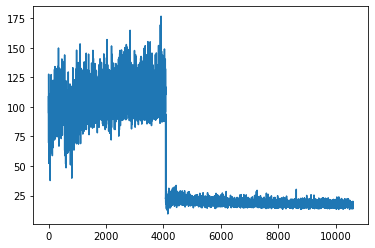

tensor(14.6413, grad_fn=<MulBackward0>)


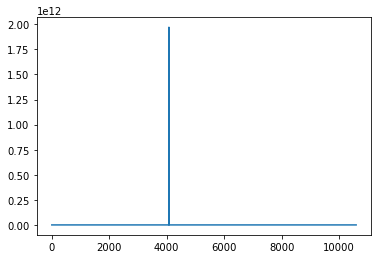

tensor(11.0569, grad_fn=<MulBackward0>)


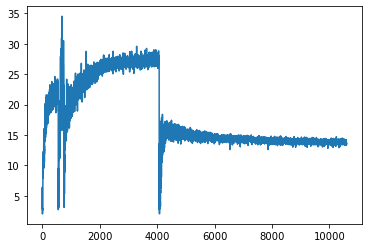

tensor(13.5985, grad_fn=<MulBackward0>)
****************************
Content Loss: 15.20881175994873
Style Loss: 9.136364936828613
Total Variation Loss: 13.749531745910645
Training Batch: 6501 Loss: 38.094707
****************************
****************************
Content Loss: 20.868236541748047
Style Loss: 9.83962345123291
Total Variation Loss: 13.725793838500977
Training Batch: 6502 Loss: 44.433655
****************************
****************************
Content Loss: 18.14698600769043
Style Loss: 9.539006233215332
Total Variation Loss: 13.84355354309082
Training Batch: 6503 Loss: 41.529549
****************************
****************************
Content Loss: 18.9517822265625
Style Loss: 8.818305015563965
Total Variation Loss: 13.97834300994873
Training Batch: 6504 Loss: 41.748432
****************************
****************************
Content Loss: 17.141910552978516
Style Loss: 8.176153182983398
Total Variation Loss: 13.710612297058105
Training Batch: 6505 Loss: 39.028675
*

Training Batch: 6542 Loss: 40.140079
****************************
****************************
Content Loss: 14.12948989868164
Style Loss: 8.57602310180664
Total Variation Loss: 13.254487991333008
Training Batch: 6543 Loss: 35.959999
****************************
****************************
Content Loss: 17.237884521484375
Style Loss: 8.322891235351562
Total Variation Loss: 13.798726081848145
Training Batch: 6544 Loss: 39.359501
****************************
****************************
Content Loss: 15.23979377746582
Style Loss: 8.50269889831543
Total Variation Loss: 13.76183795928955
Training Batch: 6545 Loss: 37.504330
****************************
****************************
Content Loss: 18.135692596435547
Style Loss: 7.926916599273682
Total Variation Loss: 13.990830421447754
Training Batch: 6546 Loss: 40.053440
****************************
****************************
Content Loss: 19.649755477905273
Style Loss: 9.415285110473633
Total Variation Loss: 14.264863967895508
Training B

****************************
Content Loss: 19.16469383239746
Style Loss: 10.26354694366455
Total Variation Loss: 13.824496269226074
Training Batch: 6584 Loss: 43.252739
****************************
****************************
Content Loss: 14.767499923706055
Style Loss: 9.48287582397461
Total Variation Loss: 13.412636756896973
Training Batch: 6585 Loss: 37.663013
****************************
****************************
Content Loss: 18.23690414428711
Style Loss: 9.606584548950195
Total Variation Loss: 13.84222412109375
Training Batch: 6586 Loss: 41.685715
****************************
****************************
Content Loss: 19.625131607055664
Style Loss: 10.012164115905762
Total Variation Loss: 14.041449546813965
Training Batch: 6587 Loss: 43.678745
****************************
****************************
Content Loss: 15.590997695922852
Style Loss: 7.769301891326904
Total Variation Loss: 14.22344970703125
Training Batch: 6588 Loss: 37.583748
****************************
*********

Training Batch: 6625 Loss: 41.713264
****************************
****************************
Content Loss: 16.59621238708496
Style Loss: 10.123502731323242
Total Variation Loss: 13.831551551818848
Training Batch: 6626 Loss: 40.551266
****************************
****************************
Content Loss: 17.903493881225586
Style Loss: 9.250999450683594
Total Variation Loss: 13.765958786010742
Training Batch: 6627 Loss: 40.920452
****************************
****************************
Content Loss: 19.093971252441406
Style Loss: 8.956233978271484
Total Variation Loss: 13.855485916137695
Training Batch: 6628 Loss: 41.905693
****************************
****************************
Content Loss: 15.696271896362305
Style Loss: 8.142437934875488
Total Variation Loss: 13.80167293548584
Training Batch: 6629 Loss: 37.640385
****************************
****************************
Content Loss: 19.16240692138672
Style Loss: 10.207279205322266
Total Variation Loss: 13.922982215881348
Traini

****************************
Content Loss: 16.232643127441406
Style Loss: 10.736749649047852
Total Variation Loss: 13.864106178283691
Training Batch: 6667 Loss: 40.833500
****************************
****************************
Content Loss: 16.82984161376953
Style Loss: 9.57961368560791
Total Variation Loss: 13.956474304199219
Training Batch: 6668 Loss: 40.365929
****************************
****************************
Content Loss: 16.38456916809082
Style Loss: 9.040658950805664
Total Variation Loss: 13.743607521057129
Training Batch: 6669 Loss: 39.168835
****************************
****************************
Content Loss: 20.532629013061523
Style Loss: 10.603781700134277
Total Variation Loss: 14.124484062194824
Training Batch: 6670 Loss: 45.260895
****************************
****************************
Content Loss: 19.008235931396484
Style Loss: 8.493081092834473
Total Variation Loss: 14.195108413696289
Training Batch: 6671 Loss: 41.696426
****************************
******

Training Batch: 6708 Loss: 41.985817
****************************
****************************
Content Loss: 18.20929718017578
Style Loss: 8.941669464111328
Total Variation Loss: 14.120610237121582
Training Batch: 6709 Loss: 41.271576
****************************
****************************
Content Loss: 15.797868728637695
Style Loss: 9.290027618408203
Total Variation Loss: 13.70054817199707
Training Batch: 6710 Loss: 38.788445
****************************
****************************
Content Loss: 15.76014518737793
Style Loss: 9.927088737487793
Total Variation Loss: 13.57479190826416
Training Batch: 6711 Loss: 39.262024
****************************
****************************
Content Loss: 15.872636795043945
Style Loss: 9.18281078338623
Total Variation Loss: 13.827287673950195
Training Batch: 6712 Loss: 38.882736
****************************
****************************
Content Loss: 17.89141273498535
Style Loss: 10.604408264160156
Total Variation Loss: 13.718367576599121
Training B

****************************
Content Loss: 15.956552505493164
Style Loss: 8.992936134338379
Total Variation Loss: 13.950714111328125
Training Batch: 6750 Loss: 38.900204
****************************
****************************
Content Loss: 15.570816040039062
Style Loss: 8.9774751663208
Total Variation Loss: 13.797246932983398
Training Batch: 6751 Loss: 38.345535
****************************
****************************
Content Loss: 19.09238624572754
Style Loss: 10.413389205932617
Total Variation Loss: 13.622841835021973
Training Batch: 6752 Loss: 43.128616
****************************
****************************
Content Loss: 17.849777221679688
Style Loss: 9.622749328613281
Total Variation Loss: 13.931364059448242
Training Batch: 6753 Loss: 41.403893
****************************
****************************
Content Loss: 15.44958209991455
Style Loss: 9.575084686279297
Total Variation Loss: 13.649638175964355
Training Batch: 6754 Loss: 38.674305
****************************
********

Training Batch: 6791 Loss: 39.514931
****************************
****************************
Content Loss: 15.895892143249512
Style Loss: 9.560685157775879
Total Variation Loss: 13.904317855834961
Training Batch: 6792 Loss: 39.360893
****************************
****************************
Content Loss: 18.655548095703125
Style Loss: 9.382086753845215
Total Variation Loss: 13.855633735656738
Training Batch: 6793 Loss: 41.893269
****************************
****************************
Content Loss: 16.062549591064453
Style Loss: 11.412775993347168
Total Variation Loss: 13.343855857849121
Training Batch: 6794 Loss: 40.819183
****************************
****************************
Content Loss: 14.614383697509766
Style Loss: 8.205803871154785
Total Variation Loss: 14.020734786987305
Training Batch: 6795 Loss: 36.840919
****************************
****************************
Content Loss: 15.556665420532227
Style Loss: 8.768038749694824
Total Variation Loss: 13.71642017364502
Train

****************************
Content Loss: 16.065418243408203
Style Loss: 8.236202239990234
Total Variation Loss: 13.930007934570312
Training Batch: 6833 Loss: 38.231628
****************************
****************************
Content Loss: 16.200008392333984
Style Loss: 9.013216018676758
Total Variation Loss: 13.654768943786621
Training Batch: 6834 Loss: 38.867992
****************************
****************************
Content Loss: 16.01848602294922
Style Loss: 11.569869995117188
Total Variation Loss: 13.197931289672852
Training Batch: 6835 Loss: 40.786285
****************************
****************************
Content Loss: 12.551557540893555
Style Loss: 8.689021110534668
Total Variation Loss: 13.379325866699219
Training Batch: 6836 Loss: 34.619904
****************************
****************************
Content Loss: 17.098739624023438
Style Loss: 8.474554061889648
Total Variation Loss: 13.809727668762207
Training Batch: 6837 Loss: 39.383022
****************************
*****

Training Batch: 6874 Loss: 41.002342
****************************
****************************
Content Loss: 18.600914001464844
Style Loss: 8.577055931091309
Total Variation Loss: 13.850672721862793
Training Batch: 6875 Loss: 41.028645
****************************
****************************
Content Loss: 14.417094230651855
Style Loss: 9.928186416625977
Total Variation Loss: 13.874135971069336
Training Batch: 6876 Loss: 38.219414
****************************
****************************
Content Loss: 18.148235321044922
Style Loss: 8.82245922088623
Total Variation Loss: 14.075113296508789
Training Batch: 6877 Loss: 41.045807
****************************
****************************
Content Loss: 21.404390335083008
Style Loss: 13.760309219360352
Total Variation Loss: 13.564377784729004
Training Batch: 6878 Loss: 48.729076
****************************
****************************
Content Loss: 17.509231567382812
Style Loss: 10.793109893798828
Total Variation Loss: 13.43784236907959
Train

****************************
Content Loss: 16.20807456970215
Style Loss: 8.531817436218262
Total Variation Loss: 13.684041976928711
Training Batch: 6916 Loss: 38.423935
****************************
****************************
Content Loss: 19.356510162353516
Style Loss: 8.250417709350586
Total Variation Loss: 13.810235977172852
Training Batch: 6917 Loss: 41.417164
****************************
****************************
Content Loss: 18.879596710205078
Style Loss: 8.848339080810547
Total Variation Loss: 14.02774429321289
Training Batch: 6918 Loss: 41.755680
****************************
****************************
Content Loss: 17.378047943115234
Style Loss: 8.883721351623535
Total Variation Loss: 13.518447875976562
Training Batch: 6919 Loss: 39.780216
****************************
****************************
Content Loss: 16.3856201171875
Style Loss: 8.57562255859375
Total Variation Loss: 13.803875923156738
Training Batch: 6920 Loss: 38.765118
****************************
**********

Training Batch: 6957 Loss: 36.767101
****************************
****************************
Content Loss: 20.4893798828125
Style Loss: 10.134960174560547
Total Variation Loss: 14.065689086914062
Training Batch: 6958 Loss: 44.690029
****************************
****************************
Content Loss: 16.192609786987305
Style Loss: 8.545827865600586
Total Variation Loss: 13.811513900756836
Training Batch: 6959 Loss: 38.549950
****************************
****************************
Content Loss: 15.987001419067383
Style Loss: 9.130236625671387
Total Variation Loss: 13.78483772277832
Training Batch: 6960 Loss: 38.902077
****************************
****************************
Content Loss: 19.464357376098633
Style Loss: 8.599056243896484
Total Variation Loss: 13.716912269592285
Training Batch: 6961 Loss: 41.780327
****************************
****************************
Content Loss: 18.632598876953125
Style Loss: 9.437763214111328
Total Variation Loss: 13.715703964233398
Trainin

****************************
Content Loss: 18.4133243560791
Style Loss: 9.34669303894043
Total Variation Loss: 13.823827743530273
Training Batch: 6999 Loss: 41.583847
****************************
****************************
Content Loss: 16.977022171020508
Style Loss: 9.736907958984375
Total Variation Loss: 13.291104316711426
Training Batch: 7000 Loss: 40.005035
****************************


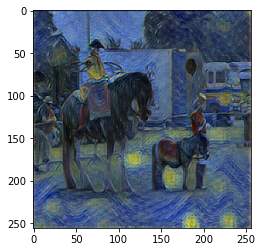

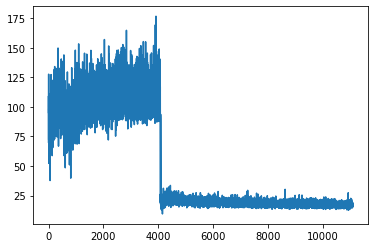

tensor(16.9770, grad_fn=<MulBackward0>)


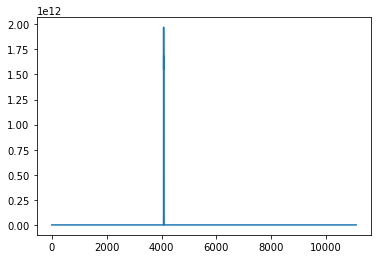

tensor(9.7369, grad_fn=<MulBackward0>)


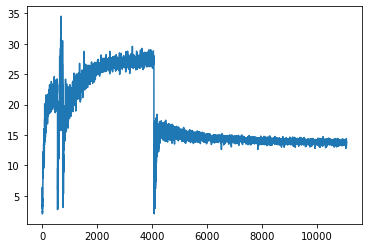

tensor(13.2911, grad_fn=<MulBackward0>)
****************************
Content Loss: 17.61551284790039
Style Loss: 9.362045288085938
Total Variation Loss: 13.820398330688477
Training Batch: 7001 Loss: 40.797958
****************************
****************************
Content Loss: 15.599790573120117
Style Loss: 8.708948135375977
Total Variation Loss: 13.687556266784668
Training Batch: 7002 Loss: 37.996296
****************************
****************************
Content Loss: 18.378633499145508
Style Loss: 10.178199768066406
Total Variation Loss: 13.751830101013184
Training Batch: 7003 Loss: 42.308662
****************************
****************************
Content Loss: 14.552092552185059
Style Loss: 11.4205904006958
Total Variation Loss: 13.717683792114258
Training Batch: 7004 Loss: 39.690369
****************************
****************************
Content Loss: 17.61433982849121
Style Loss: 8.358821868896484
Total Variation Loss: 13.8081693649292
Training Batch: 7005 Loss: 39.78133

Training Batch: 7042 Loss: 39.157299
****************************
****************************
Content Loss: 16.533447265625
Style Loss: 8.497363090515137
Total Variation Loss: 13.811845779418945
Training Batch: 7043 Loss: 38.842659
****************************
****************************
Content Loss: 20.453102111816406
Style Loss: 8.752189636230469
Total Variation Loss: 14.133810043334961
Training Batch: 7044 Loss: 43.339104
****************************
****************************
Content Loss: 17.037578582763672
Style Loss: 8.01173210144043
Total Variation Loss: 13.908421516418457
Training Batch: 7045 Loss: 38.957733
****************************
****************************
Content Loss: 16.99806785583496
Style Loss: 9.272490501403809
Total Variation Loss: 13.664877891540527
Training Batch: 7046 Loss: 39.935436
****************************
****************************
Content Loss: 15.636651992797852
Style Loss: 8.413179397583008
Total Variation Loss: 13.615782737731934
Training B

****************************
Content Loss: 16.367507934570312
Style Loss: 9.078497886657715
Total Variation Loss: 13.660506248474121
Training Batch: 7084 Loss: 39.106514
****************************
****************************
Content Loss: 18.224992752075195
Style Loss: 8.163159370422363
Total Variation Loss: 13.972800254821777
Training Batch: 7085 Loss: 40.360954
****************************
****************************
Content Loss: 17.92719268798828
Style Loss: 10.40318775177002
Total Variation Loss: 13.525239944458008
Training Batch: 7086 Loss: 41.855621
****************************
****************************
Content Loss: 17.849891662597656
Style Loss: 10.065649032592773
Total Variation Loss: 14.241652488708496
Training Batch: 7087 Loss: 42.157192
****************************
****************************
Content Loss: 20.67361068725586
Style Loss: 9.11755657196045
Total Variation Loss: 14.571101188659668
Training Batch: 7088 Loss: 44.362270
****************************
*******

Training Batch: 7125 Loss: 38.966869
****************************
****************************
Content Loss: 20.167287826538086
Style Loss: 10.369241714477539
Total Variation Loss: 13.831645965576172
Training Batch: 7126 Loss: 44.368176
****************************
****************************
Content Loss: 16.34453010559082
Style Loss: 9.0343599319458
Total Variation Loss: 13.569009780883789
Training Batch: 7127 Loss: 38.947899
****************************
****************************
Content Loss: 16.740398406982422
Style Loss: 9.49030876159668
Total Variation Loss: 13.727999687194824
Training Batch: 7128 Loss: 39.958706
****************************
****************************
Content Loss: 17.615951538085938
Style Loss: 10.423761367797852
Total Variation Loss: 13.479854583740234
Training Batch: 7129 Loss: 41.519569
****************************
****************************
Content Loss: 17.082157135009766
Style Loss: 8.055130958557129
Total Variation Loss: 13.706772804260254
Trainin

****************************
Content Loss: 15.876554489135742
Style Loss: 7.822840213775635
Total Variation Loss: 13.864760398864746
Training Batch: 7167 Loss: 37.564156
****************************
****************************
Content Loss: 18.74578094482422
Style Loss: 10.38631534576416
Total Variation Loss: 13.785340309143066
Training Batch: 7168 Loss: 42.917435
****************************
****************************
Content Loss: 17.53783416748047
Style Loss: 9.739577293395996
Total Variation Loss: 13.328513145446777
Training Batch: 7169 Loss: 40.605927
****************************
****************************
Content Loss: 16.95391273498535
Style Loss: 9.239143371582031
Total Variation Loss: 13.513559341430664
Training Batch: 7170 Loss: 39.706615
****************************
****************************
Content Loss: 17.58332633972168
Style Loss: 8.960890769958496
Total Variation Loss: 13.668705940246582
Training Batch: 7171 Loss: 40.212921
****************************
*********

Training Batch: 7208 Loss: 39.365768
****************************
****************************
Content Loss: 16.87612533569336
Style Loss: 8.970549583435059
Total Variation Loss: 13.908132553100586
Training Batch: 7209 Loss: 39.754807
****************************
****************************
Content Loss: 15.818815231323242
Style Loss: 8.785693168640137
Total Variation Loss: 13.69520092010498
Training Batch: 7210 Loss: 38.299709
****************************
****************************
Content Loss: 13.898195266723633
Style Loss: 10.626978874206543
Total Variation Loss: 13.837074279785156
Training Batch: 7211 Loss: 38.362247
****************************
****************************
Content Loss: 16.002016067504883
Style Loss: 8.644798278808594
Total Variation Loss: 13.784791946411133
Training Batch: 7212 Loss: 38.431606
****************************
****************************
Content Loss: 18.09748077392578
Style Loss: 10.043078422546387
Total Variation Loss: 13.568574905395508
Traini

****************************
Content Loss: 18.478036880493164
Style Loss: 10.028446197509766
Total Variation Loss: 13.86725902557373
Training Batch: 7250 Loss: 42.373741
****************************
****************************
Content Loss: 16.986797332763672
Style Loss: 8.814949989318848
Total Variation Loss: 13.810080528259277
Training Batch: 7251 Loss: 39.611828
****************************
****************************
Content Loss: 16.889925003051758
Style Loss: 8.119239807128906
Total Variation Loss: 13.83564567565918
Training Batch: 7252 Loss: 38.844810
****************************
****************************
Content Loss: 15.855103492736816
Style Loss: 8.046220779418945
Total Variation Loss: 13.8887939453125
Training Batch: 7253 Loss: 37.790119
****************************
****************************
Content Loss: 17.637636184692383
Style Loss: 9.09535026550293
Total Variation Loss: 13.818353652954102
Training Batch: 7254 Loss: 40.551338
****************************
*********

Training Batch: 7291 Loss: 39.538513
****************************
****************************
Content Loss: 19.10975456237793
Style Loss: 8.803461074829102
Total Variation Loss: 13.821760177612305
Training Batch: 7292 Loss: 41.734978
****************************
****************************
Content Loss: 18.89081573486328
Style Loss: 10.868630409240723
Total Variation Loss: 13.468241691589355
Training Batch: 7293 Loss: 43.227688
****************************
****************************
Content Loss: 18.447025299072266
Style Loss: 9.1300630569458
Total Variation Loss: 13.634519577026367
Training Batch: 7294 Loss: 41.211609
****************************
****************************
Content Loss: 15.028721809387207
Style Loss: 8.876954078674316
Total Variation Loss: 13.771151542663574
Training Batch: 7295 Loss: 37.676826
****************************
****************************
Content Loss: 23.216096878051758
Style Loss: 9.660208702087402
Total Variation Loss: 13.843188285827637
Training

****************************
Content Loss: 22.644859313964844
Style Loss: 10.513697624206543
Total Variation Loss: 13.619282722473145
Training Batch: 7333 Loss: 46.777840
****************************
****************************
Content Loss: 15.891826629638672
Style Loss: 7.990076541900635
Total Variation Loss: 13.852913856506348
Training Batch: 7334 Loss: 37.734818
****************************
****************************
Content Loss: 14.812771797180176
Style Loss: 8.6084566116333
Total Variation Loss: 13.929216384887695
Training Batch: 7335 Loss: 37.350445
****************************
****************************
Content Loss: 15.564386367797852
Style Loss: 10.698351860046387
Total Variation Loss: 13.734549522399902
Training Batch: 7336 Loss: 39.997288
****************************
****************************
Content Loss: 16.266294479370117
Style Loss: 9.79991626739502
Total Variation Loss: 14.311513900756836
Training Batch: 7337 Loss: 40.377724
****************************
******

Training Batch: 7374 Loss: 41.971607
****************************
****************************
Content Loss: 19.936473846435547
Style Loss: 9.296018600463867
Total Variation Loss: 13.858363151550293
Training Batch: 7375 Loss: 43.090855
****************************
****************************
Content Loss: 18.22257423400879
Style Loss: 9.4520902633667
Total Variation Loss: 13.583946228027344
Training Batch: 7376 Loss: 41.258610
****************************
****************************
Content Loss: 17.65706443786621
Style Loss: 9.4110689163208
Total Variation Loss: 13.618451118469238
Training Batch: 7377 Loss: 40.686584
****************************
****************************
Content Loss: 17.66277313232422
Style Loss: 7.761340618133545
Total Variation Loss: 13.991795539855957
Training Batch: 7378 Loss: 39.415909
****************************
****************************
Content Loss: 17.151607513427734
Style Loss: 8.746023178100586
Total Variation Loss: 13.816139221191406
Training Bat

****************************
Content Loss: 14.024970054626465
Style Loss: 9.733431816101074
Total Variation Loss: 13.42032241821289
Training Batch: 7416 Loss: 37.178726
****************************
****************************
Content Loss: 17.070514678955078
Style Loss: 7.988992214202881
Total Variation Loss: 13.482749938964844
Training Batch: 7417 Loss: 38.542259
****************************
****************************
Content Loss: 16.628591537475586
Style Loss: 8.245613098144531
Total Variation Loss: 13.65292739868164
Training Batch: 7418 Loss: 38.527130
****************************
****************************
Content Loss: 16.7803955078125
Style Loss: 8.201632499694824
Total Variation Loss: 13.661465644836426
Training Batch: 7419 Loss: 38.643494
****************************


KeyboardInterrupt: 

In [114]:
for epoch in range(2):
    transformation_net.train()
    for batch, _ in enumerate(range(0, MAX_TRAIN, BATCH_SIZE)):
        # Skip what we've already done
        if epoch == 0 and batch < 7419:
            continue
        
        # The content batch is the same as the train batch, except train batch has noise added to it
        train_batch = load_training_batch(batch, BATCH_SIZE, 'train')
        content_batch = np.copy(train_batch)

        # Add noise to the training batch
        train_batch = add_noise(train_batch)

        # Convert the batches to tensors
        train_batch = torch.from_numpy(train_batch).float()
        content_batch = torch.from_numpy(content_batch).float()

        # Zero the gradients
        opt.zero_grad()

        # Forward propagate
        gen_images = transformation_net(train_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])

        # Backprop
        loss.backward()

        # Clip the gradient to minimize chance of exploding gradients
        torch.nn.utils.clip_grad_norm_(transformation_net.parameters(), 1.0)

        # Apply gradients
        opt.step()

        print("Training Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))
        print('****************************')
        
        if batch % 500 == 499:
            training_show_img()
            plot_losses()
        
    transformation_net.eval()
    for batch, _ in enumerate(range(MAX_TRAIN, MAX_VAL, BATCH_SIZE)):
        # The content batch is the same as the train batch, except train batch has noise added to it
        val_batch = load_training_batch(batch, BATCH_SIZE, 'val')
        content_batch = np.copy(val_batch)
        
        # Add noise to the training batch
        val_batch = add_noise(val_batch)
        
        # Convert the batches to tensors
        val_batch = torch.from_numpy(val_batch).float()
        content_batch = torch.from_numpy(content_batch).float()
        
        # Forward propagate
        gen_images = transformation_net(val_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])
        
        print("Validation Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))
    
    

In [116]:
torch.save(transformation_net.state_dict(), 'starry_night_1e6_batch_7419.pt')

In [ ]:
training_show_img()

In [ ]:
plot_losses()

In [ ]:
mona_lisa = np.asarray(Image.open('data/mona_lisa.jpg').resize(IMG_DIMENSIONS)).transpose(2, 0, 1)[0:3]
mona_lisa.reshape(1, 3, 256, 256)

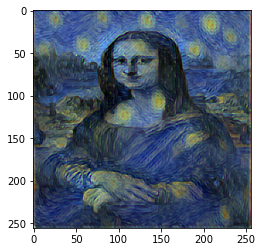

In [115]:
show_img(mona_lisa)